In [1]:
# Jupyter's default tab completion is broken right now;
# this seems to be a workaround until it's fixed, per
# https://github.com/jupyter/notebook/issues/3763#issuecomment-745701270
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [2]:
from copy import deepcopy
from datetime import datetime
from itertools import cycle, islice, product
from pathlib import Path
import networkx as nx

import numpy as np
import pandas as pd
import pyphi
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display

import compute
import utils
from utils import substate
from model import Model, Params
import dynamics
import connectedness

## Functions for computing causal chains

In [3]:
def get_effects_from_source(
    transitions, source_nodes=None, max_purview_size=5, max_mechanism_size=5,
):

    if source_nodes == None:
        source_nodes = range(len(transitions[0].network))

    source_subsets = list(
        pyphi.utils.powerset(source_nodes, nonempty=True, max_size=max_mechanism_size)
    )

    all_purviews = list(
        pyphi.utils.powerset(
            range(len(transitions[0].network)), nonempty=True, max_size=max_purview_size
        )
    )

    past_effect_subsets = []
    effects = []

    # loop through all transitions
    for i, t in enumerate(tqdm(transitions, desc="Computing legal effects")):

        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.EFFECT,
            mechanisms=set(past_effect_subsets + source_subsets),
            purviews=all_purviews,
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        effects.append(
            [
                [effect.mechanism, effect.purview, effect.alpha]
                for effect in account.irreducible_effects
            ]
        )

        # updating which sink_nodes subsets will be used as mechanisms in the next iteration.
        # only those that are completely contained in a an actual effect from this iteration.
        past_effect_subsets = [
            mechanism_subset
            for mechanism_subset in all_purviews
            if any(
                [
                    all([element in effect.purview for element in mechanism_subset])
                    for effect in account.irreducible_effects
                ]
            )
        ]
    return effects

def get_causes_of_sink(
    transitions, sink_nodes=None, max_purview_size=5, max_mechanism_size=5,
):

    if sink_nodes == None:
        sink_nodes = range(len(transitions[0].network))

    sink_subsets = list(
        pyphi.utils.powerset(sink_nodes, nonempty=True, max_size=max_mechanism_size)
    )

    all_subsets = list(
        pyphi.utils.powerset(
            range(len(transitions[0].network)),
            nonempty=True,
            max_size=max_mechanism_size,
        )
    )

    past_cause_subsets = []
    causes = []
    # loop through all transitions
    for i, t in enumerate(
        tqdm(
            reversed(transitions), total=len(transitions), desc="Computing legal causes"
        )
    ):
        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.CAUSE,
            mechanisms=set(past_cause_subsets + sink_subsets),
            purviews=all_subsets,
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        causes.append(
            [
                [cause.mechanism, cause.purview, cause.alpha]
                for cause in account.irreducible_causes
            ]
        )

        # updating which sink_nodes subsets will be used as mechanisms in the next iteration.
        # only those that are completely contained in a an actual effect from this iteration.
        past_cause_subsets = [
            mechanism_subset
            for mechanism_subset in all_subsets
            if any(
                [
                    all([element in effect.purview for element in mechanism_subset])
                    for effect in account.irreducible_causes
                ]
            )
        ]

    return causes

def check_legal_chain(
    cause_effects,
    chain,
    source_subset,
    sink_subset,
    time_restricted_source,
    all_source_subsets,
    all_sink_subsets,
    direction="cause",
):

    mechanisms = [
        cause_effects[chain[i]][0] for i, cause_effects in enumerate(cause_effects)
    ]
    purviews = [
        cause_effects[chain[i]][1] for i, cause_effects in enumerate(cause_effects)
    ]

    if direction == "cause":

        if time_restricted_source and all_source_subsets:
            legal_source = all([element in source_subset for element in purviews[-1]])
        elif all_source_subsets:
            legal_source = any(
                [
                    all([element in source_subset for element in purview])
                    for purview in purviews
                ]
            )
        elif time_restricted_source:
            legal_source = purviews[0] == source_subset
        else:
            legal_source = any([purview == source_subset for purview in purviews])

        if all_sink_subsets:
            legal_sink = all([element in sink_subset for element in mechanisms[0]])
        else:
            legal_sink = mechanisms[0] == sink_subset

    else:  # for effects
        if time_restricted_source and all_source_subsets:
            legal_source = all([element in source_subset for element in mechanisms[0]])
        elif all_source_subsets:
            legal_source = any(
                [
                    all([element in source_subset for element in mechanism])
                    for mechanism in mechanisms
                ]
            )
        elif time_restricted_source:
            legal_source = mechanisms[0] == source_subset
        else:
            legal_source = any([mechanism == source_subset for mechanism in mechanisms])

        if all_sink_subsets:
            legal_sink = all([element in sink_subset for element in purviews[-1]])
        else:
            legal_sink = purviews[-1] == sink_subset

    return legal_source and legal_sink

def get_effect_chains(
    effects,
    start_t,
    source_subset,
    sink_subset,
    all_source_subsets=False,
    all_sink_subsets=False,
    time_restricted_source=False,
):

    relevant_effects = effects[start_t:]

    # list all potential chains through the system (based on causal links)
    potential_chains = [
        chain for chain in product(*[range(len(links)) for links in relevant_effects])
    ]
    effect_chains = []
    chain_alphas = []

    tau = len(potential_chains[0])

    # loop through every potential chain
    for chain in tqdm(potential_chains, desc="Computing effect chains"):
        possible = True

        # check that the first mechanism is completely in the input array
        mechanisms = [effect[chain[i]][0] for i, effect in enumerate(relevant_effects)]
        last_purview = relevant_effects[-1][chain[-1]][1]

        if check_legal_chain(
            relevant_effects,
            chain,
            source_subset,
            sink_subset,
            time_restricted_source,
            all_source_subsets,
            all_sink_subsets,
            direction="effect",
        ):

            for t in range(tau - 1):
                effect_purview = relevant_effects[t][chain[t]][1]
                next_mechanism = relevant_effects[t + 1][chain[t + 1]][0]

                # if not all elements in the next mechanism is in the current effect, the chain is broken
                if not all([element in effect_purview for element in next_mechanism]):
                    possible = False
                    break

            # store the possible chains with their respective alpha values
            if possible:
                effect_chain = [
                    (effect[link][0], effect[link][1], effect[link][2])
                    for effect, link in zip(relevant_effects, chain)
                ]

                # but keep only unique chains
                if not any([effect_chain == p for p in effect_chains]):
                    effect_chains.append(effect_chain)

    return effect_chains  # causal_bind

def get_cause_chains(
    causes,
    end_t,
    source_subset,
    sink_subset,
    all_source_subsets=False,
    all_sink_subsets=False,
    time_restricted_source=False,
):

    relevant_causes = causes[:end_t]

    # list all potential chains through the system (based on causal links)
    potential_chains = [
        chain for chain in product(*[range(len(links)) for links in relevant_causes])
    ]
    cause_chains = []
    chain_alphas = []

    tau = len(relevant_causes)

    potential = 0
    no_link = 0
    # loop through every potential chain
    for chain in tqdm(potential_chains, desc="Computing cause chains"):
        possible = True

        # check that the first mechanism is completely in the input array
        sink_mechanism = relevant_causes[0][chain[0]][0]
        purviews = [effect[chain[i]][1] for i, effect in enumerate(relevant_causes)]

        if check_legal_chain(
            relevant_causes,
            chain,
            source_subset,
            sink_subset,
            time_restricted_source,
            all_source_subsets,
            all_sink_subsets,
        ):
            for t in range(tau - 1):
                cause_purview = relevant_causes[t][chain[t]][1]
                next_mechanism = relevant_causes[t + 1][chain[t + 1]][0]

                # if not all elements in the next mechanism is in the current cause, the chain is broken
                if not all([element in cause_purview for element in next_mechanism]):
                    possible = False
                    break

            # store the possible chains with their respective alpha values
            if possible:
                cause_chain = [
                    (cause[link][0], cause[link][1], cause[link][2])
                    for cause, link in zip(relevant_causes, chain)
                ]

                # but keep only unique chains
                if not any([cause_chain == p for p in cause_chains]):
                    cause_chains.append(cause_chain)

    return cause_chains  # causal_bind

def get_bundled_chains(possible_chains):
    bundled_chains = (
        [
            list(set([chain[link] for chain in possible_chains]))
            for link in range(len(possible_chains[0]))
        ]
        if len(possible_chains) > 0
        else [[("NA", "NA", 0)]]
    )
    return bundled_chains

def get_bundle_strength(bundled_chains):
    return min([sum([link[2] for link in links]) for links in bundled_chains])



def get_system_causal_bundle(
    network,
    network_states,
    source_nodes,
    sink_nodes,
    max_purview_size=4,
    max_mechainsm_size=4,
    start_t=0,
    all_source_subsets=True,
    all_sink_subsets=True,
):

    transitions = [
        pyphi.actual.Transition(
            network,
            network_state_1,
            network_state_2,
            network.node_indices,
            network.node_indices,
        )
        for network_state_1, network_state_2 in zip(
            network_states[:-1], network_states[1:]
        )
    ]

    transitions = transitions[start_t:] if start_t > 0 else transitions

    effects = get_effects_from_source(
        transitions,
        source_nodes=source_nodes,
        max_purview_size=max_purview_size,
        max_mechanism_size=max_mechainsm_size,
    )
    
    causes = get_causes_of_sink(
        transitions,
        sink_nodes=sink_nodes,
        max_purview_size=max_purview_size,
        max_mechanism_size=max_mechainsm_size,
    )
    
    cause_chains = get_cause_chains(
        causes,
        len(transitions),
        source_nodes,
        sink_nodes,
        all_source_subsets=all_source_subsets,
        all_sink_subsets=all_sink_subsets,
    )
    
    effect_chains = get_effect_chains(
        effects,
        0,
        source_nodes,
        sink_nodes,
        all_source_subsets=all_source_subsets,
        all_sink_subsets=all_sink_subsets,
    )
    
    bundled_causes = get_bundled_chains(cause_chains)
    bundled_effects = get_bundled_chains(effect_chains)

    connectedness = sum(
        [get_bundle_strength(bundled_causes), get_bundle_strength(bundled_effects)]
    )

    return {
        "causes": bundled_causes,
        "effects": bundled_effects,
        "connectedness": connectedness,
    }

def draw_connectedness(
    network, input_array, system, network_states, causal_bundle, title_prefix=""
):
    # define network
    G = nx.DiGraph()

    # define nodes
    node_states = []
    border_color = []
    node_position = dict()
    node_label = []
    for t in range(len(network_states)):
        for i in input_array + system:
            node_name = network.node_labels[i] + " " + str(t)
            node_label.append(node_name)
            node_states.append("gray" if network_states[t][i] == 1 else "w")
            border_color.append("k" if i in system else "b")
            node_position[node_name] = (t, i)
            G.add_node(node_name)

    # define edges
    edge_colors = []
    edge_styles = []
    edge_labels = []
    edge_widths = dict()
    counter = 0
    for direction, bundle in causal_bundle.items():
        if not direction == "connectedness":
            for t, links in enumerate(bundle):
                if direction == "causes":
                    for link in links:
                        if not link[0] == "NA":
                            mechanism = link[0]
                            purview = link[1]
                            alpha = link[2]

                            for m in mechanism:
                                for p in purview:
                                    source = (
                                        network.node_labels[m]
                                        + " "
                                        + str(len(network_states) - 1 - (t))
                                    )
                                    target = (
                                        network.node_labels[p]
                                        + " "
                                        + str(len(network_states) - 1 - (t + 1))
                                    )
                                    a = 0.11 + 2 * alpha

                                    if not (source, target) in edge_widths.keys():
                                        edge_colors.append("r")
                                        edge_widths[(source, target)] = a
                                        edge_labels.append((source, target))
                                    else:
                                        edge_widths[(source, target)] += a

                if direction == "effects":
                    for link in links:
                        if not link[0] == "NA":
                            mechanism = link[0]
                            purview = link[1]
                            alpha = link[2]

                            for m in mechanism:
                                for p in purview:
                                    source = network.node_labels[m] + " " + str((t))
                                    target = network.node_labels[p] + " " + str((t + 1))
                                    a = 0.11 + 2 * alpha

                                    if not (source, target) in edge_widths.keys():
                                        edge_colors.append("g")
                                        edge_widths[(source, target)] = a
                                        edge_labels.append((source, target))
                                    else:
                                        edge_widths[(source, target)] += a
    G.add_edges_from(edge_labels)

    fig, ax = plt.subplots(figsize=(10, 10))

    nx.draw_networkx_nodes(
        G,
        node_position,
        node_color=node_states,
        node_size=500,
        node_shape="o",
        label=node_label,
        edgecolors=border_color,
        linewidths=3,
        ax=ax,
    )

    nx.draw_networkx_edges(
        G,
        node_position,
        edgelist=edge_labels,
        width=list(edge_widths.values()),
        edge_color=edge_colors,
        arrowstyle="-|>",
        arrowsize=20,
        connectionstyle="arc3,rad=0.1",
        ax=ax,
    )

    nx.draw_networkx_labels(
        G, node_position, {l: l[:-2] for l in node_label}, font_size=11, ax=ax
    )

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.title(
        title_prefix + "connectedness = {}".format(causal_bundle["connectedness"])
    )

    plt.xticks(
        ticks=list(range(len(network_states))),
        labels=[
            "t={}".format(-(len(network_states) - (t + 1)))
            for t in range(len(network_states))
        ],
    )
    plt.yticks(ticks=list(range(len(network))), labels=network.node_labels)
    plt.xlabel("time")
    plt.ylabel("nodes")
    return G

def get_all_subset_connectedness(
    network,
    network_states,
    source_nodes,
    sink_nodes,
    max_purview_size=4,
    max_mechainsm_size=4,
    start_t=0,
):
    for sink_subset in pyphi.utils.powerset(sink_nodes, nonempty=True):
        bundle = dict()
        max_source = ()
        connectedness = 0

        bundle = get_system_causal_bundle(
            network,
            network_states,
            source_nodes,
            sink_subset,
            max_purview_size=4,
            max_mechainsm_size=4,
            start_t=0,
            all_source_subsets=True,
            all_sink_subsets=False,
        )

        draw_connectedness(
            network,
            source_nodes,
            sink_nodes,
            network_states,
            bundle,
            title_prefix="{} ".format(sink_subset),
        )

    bundle = get_system_causal_bundle(
        network,
        network_states,
        source_nodes,
        sink_nodes,
        max_purview_size=4,
        max_mechainsm_size=4,
        start_t=0,
        all_source_subsets=True,
        all_sink_subsets=True,
    )
    draw_connectedness(
        network, input_array, system, network_states, bundle, title_prefix="System "
    )

# Create simple system
- two inputs (I1 and I2) and three system nodes (ABC).
- I1 inputs to A, I2 inputs to B, and C gets inputs from A and B. No feedback.
- All nodes have the same noise (n) and self loops (s). 
- A and B have the same input strength (i)
- The inputs and A and B have lateral connections (I1 <-> I2, and A <-> B) given by l.
- C turns ON only if both A and B are on, turns OFF if one is on, and is noisy otherwise (has some weird self loop modulation)

In [4]:
labels = ["I1", "I2", "A", "B", "C"]

n = 0.05
s = 0.4
i = 0.3
l = 0.2
tpm = [
    [n, n, n, n, n],
    [s, n + l, i, n, n],
    [n + l, s, n, i, n],
    [s + l, s + l, i, i, n],
    [n, n, s, n + l, 0],
    [s, n + l, 1 - n, n + l, 0],
    [n + l, s, s, i, 0],
    [s, s, 1 - n, i, 0],
    [n, n, n + l, s, 0],
    [s, n + l, i + l, s, 0],
    [n + l, s, n, 1 - n, 0],
    [s + l, s + l, i, 1 - n, 0],
    [n, n, s + l, s + l, 1],
    [s, n + l, 1, s + l, 1],
    [n + l, s, s + l, i + l, 1],
    [s, s, 1 - n, 1 - n, 1],
    [n, n, n, n, s + n * 2],
    [s, n + l, i, n, s + n * 2],
    [n + l, s, n, i, s + n * 2],
    [s + l, s + l, i, i, s + n * 2],
    [n, n, s, n + l, s / 2],
    [s, n + l, 1 - n, n + l, s / 2],
    [n + l, s, s, i, s / 2],
    [s, s, 1 - n, i, s / 2],
    [n, n, n + l, s, s / 2],
    [s, n + l, i + l, s, s / 2],
    [n + l, s, n, 1 - n, s / 2],
    [s + l, s + l, i, 1 - n, s / 2],
    [n, n, s + l, s + l, 1 - n],
    [s, n + l, 1, s + l, 1 - n],
    [n + l, s, s + l, i + l, 1 - n],
    [s, s, 1 - n, 1 - n, 1 - n],
]

network = pyphi.network.Network(tpm, node_labels=labels)

### Creating all the transitions for an actual sequence of states

In [5]:
input_array = (0, 1)
system = (2, 3, 4)
'''network_states = [
    (1, 1, 0, 0, 0),
    (1, 1, 0, 0, 0),
    (1, 1, 1, 1, 0),
    (1, 1, 1, 1, 0),
    (1, 1, 1, 1, 1),
    (1, 1, 1, 1, 1),
]'''
network_states = [
    (1, 1, 0, 0, 0),
    (1, 1, 1, 1, 0),
    (1, 1, 1, 1, 1),
]

transitions = [
    pyphi.actual.Transition(
        network,
        network_state_1,
        network_state_2,
        input_array + system,
        input_array + system,
    )
    for network_state_1, network_state_2 in zip(network_states[:-1], network_states[1:])
]

### computing all actual causes and effects in the transitions
Here we make choices of which elements "sources" from which we compute effects (for example only *initial* effects of input array), and which elements are the "sinks" from which we compute causes.

In [6]:
effects = get_effects_from_source(
    transitions, source_nodes=(0,1), max_purview_size=5, max_mechanism_size=5,
)
causes = get_causes_of_sink(
    transitions, sink_nodes=(2,3,4,), max_purview_size=5, max_mechanism_size=5,
)

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print('   mech,   purv,    alpha')
print('__________________________________')
causes

   mech,   purv,    alpha
__________________________________


[[[(2, 4), (2, 3), 0.274763191793],
  [(2,), (0, 2), 0.507998037557],
  [(3, 4), (2, 3), 0.232350264316],
  [(4,), (2, 3), 0.959817719408],
  [(2, 3), (0, 2), 0.085831847095],
  [(2, 3, 4), (0, 2, 3), 0.12176553523],
  [(3,), (3,), 0.435179961606]],
 [[(2,), (0,), 0.313529776943],
  [(3, 4), (1, 2), 0.070275550281],
  [(0, 3), (1, 2), 0.172080002178],
  [(0, 2, 3), (0, 1), 0.072753555451],
  [(4,), (2, 4), 0.234373511752],
  [(2, 3), (0,), 0.038930357701],
  [(0, 2), (0,), 0.182595676573],
  [(0,), (0,), 0.438721875541],
  [(3,), (1,), 0.22140573854]]]

### Find all possible chains from a particular sink (subset of input array elements) to a particular source (subset of system subsets) at t+tau
possible chains are those that 
- start in a subset of the source/input array subset (at any time)
- move to a subset of its effect purview (repeated until the end of time - 1)
- and ends in the sink/system subset at the final time-step

In [8]:
start_t = 0
end_t = 3
source_subset = (0, 1)
sink_subset = (2,)
effect_chains = get_effect_chains(
    effects,
    start_t,
    source_subset,
    sink_subset,
    all_source_subsets=True,
    all_sink_subsets=False,
)

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

In [9]:
effect_chains

[[((0,), (0, 2), 0.307662520635), ((0, 2), (2,), 0.38155600282)]]

### Do the same for cause chains

In [10]:
start_t = 0
end_t = 2
source_subset = (0, 1)
sink_subset = (2,3,4)
cause_chains = get_cause_chains(
    causes,
    end_t,
    source_subset,
    sink_subset,
    all_source_subsets=True,
    all_sink_subsets=False,
)

Computing cause chains:   0%|          | 0/63 [00:00<?, ?it/s]

In [11]:
cause_chains

[[((2, 3, 4), (0, 2, 3), 0.12176553523), ((2,), (0,), 0.313529776943)],
 [((2, 3, 4), (0, 2, 3), 0.12176553523), ((0, 2, 3), (0, 1), 0.072753555451)],
 [((2, 3, 4), (0, 2, 3), 0.12176553523), ((2, 3), (0,), 0.038930357701)],
 [((2, 3, 4), (0, 2, 3), 0.12176553523), ((0, 2), (0,), 0.182595676573)],
 [((2, 3, 4), (0, 2, 3), 0.12176553523), ((0,), (0,), 0.438721875541)],
 [((2, 3, 4), (0, 2, 3), 0.12176553523), ((3,), (1,), 0.22140573854)]]

## Next we "bundle" the chains, to avoid over counting identical links that occur in multiple chains

In [12]:

bundled_causes = get_bundled_chains(cause_chains)
bundled_effects = get_bundled_chains(effect_chains)
connectedness = max(
    [get_bundle_strength(bundled_causes), get_bundle_strength(bundled_effects)]
)
bundled_causes

[[((2, 3, 4), (0, 2, 3), 0.12176553523)],
 [((0, 2, 3), (0, 1), 0.072753555451),
  ((0,), (0,), 0.438721875541),
  ((2, 3), (0,), 0.038930357701),
  ((2,), (0,), 0.313529776943),
  ((0, 2), (0,), 0.182595676573),
  ((3,), (1,), 0.22140573854)]]

## Now we can compute the cause and effect chains from the input array to all system subsets

In [13]:
source_nodes = (0, 1)
sink_nodes = (2,3,4,)
system_bundle = get_system_causal_bundle(
    network,
    network_states,
    source_nodes,
    sink_nodes,
    max_purview_size=4,
    max_mechainsm_size=4,
    start_t=0,
    all_source_subsets=True,
    all_sink_subsets=True,
)

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/63 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

## And plot the causal chains

2021-09-07 13:16:56,740 [matplotlib.font_manager] WARNING MainProcess: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


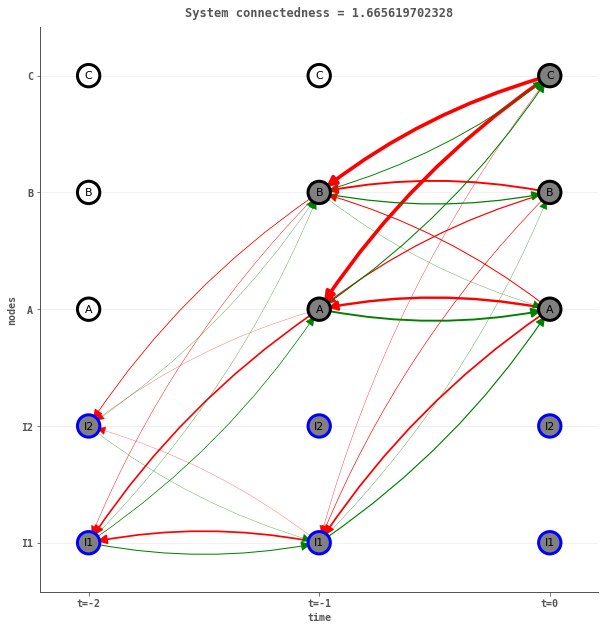

In [14]:
draw_connectedness(network, input_array, system, network_states, system_bundle, title_prefix='System ')

## we can also plot the causal chain for specific system subsets

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/4 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

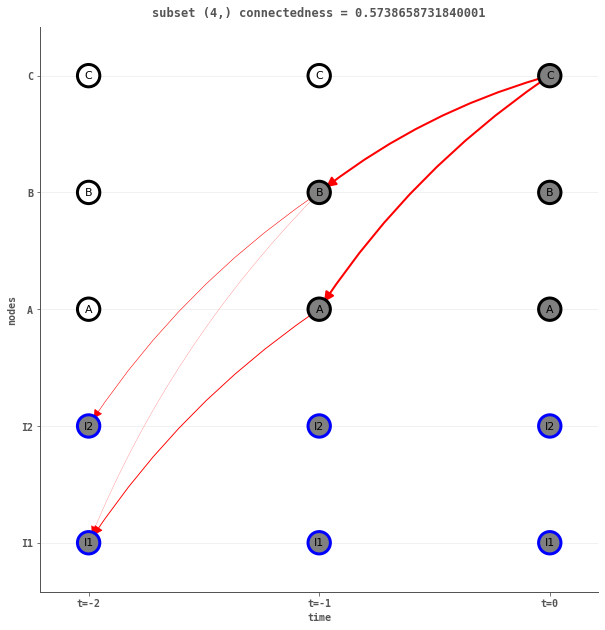

In [15]:
source_nodes = (0,1)
sink_nodes = (
    4,
)
bundle = get_system_causal_bundle(
    network,
    network_states,
    source_nodes,
    sink_nodes,
    max_purview_size=4,
    max_mechainsm_size=4,
    start_t=0,
    all_source_subsets=True,
    all_sink_subsets=False,
)
draw_connectedness(network, input_array, system, network_states, bundle,title_prefix='subset {} '.format(sink_nodes))

## Or plot all system subsets

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/3 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/1 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/4 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/15 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/18 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/15 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/63 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/2 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/63 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/21 [00:00<?, ?it/s]

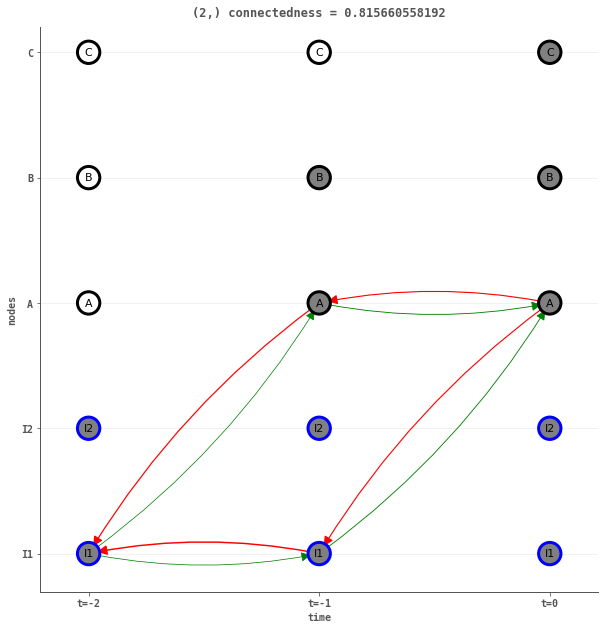

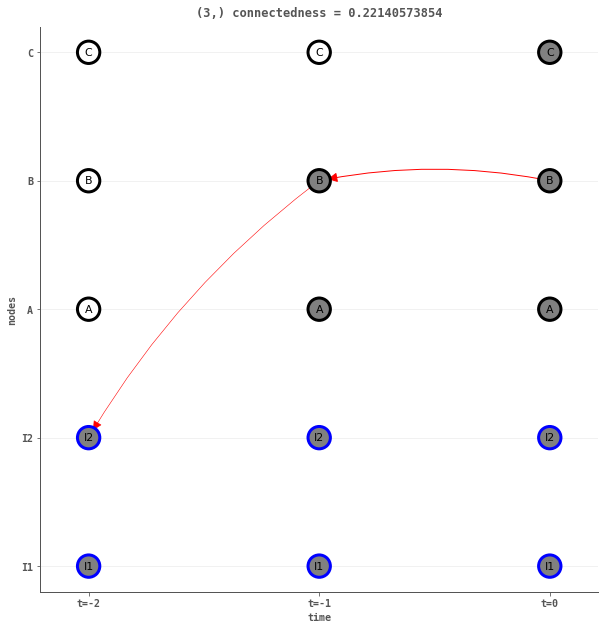

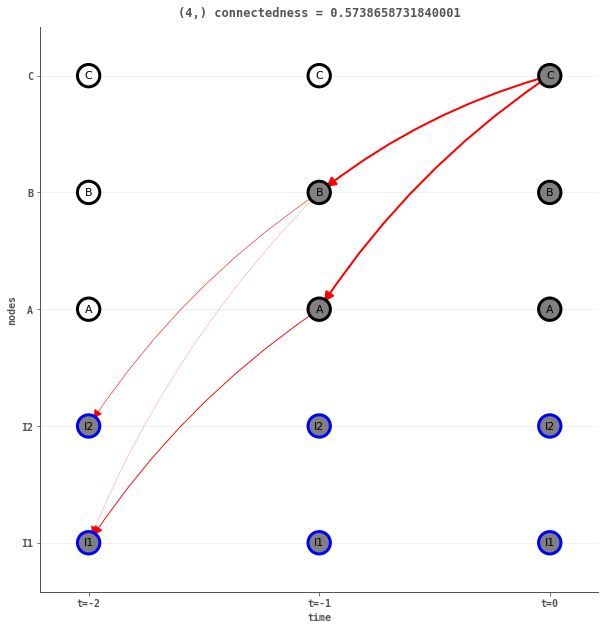

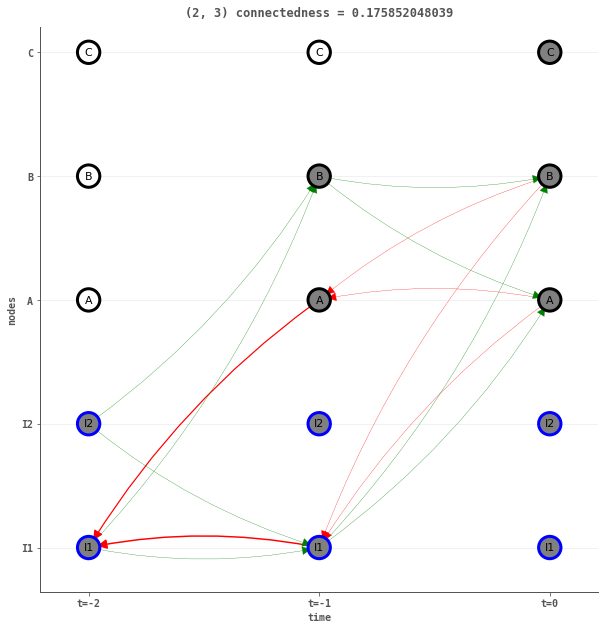

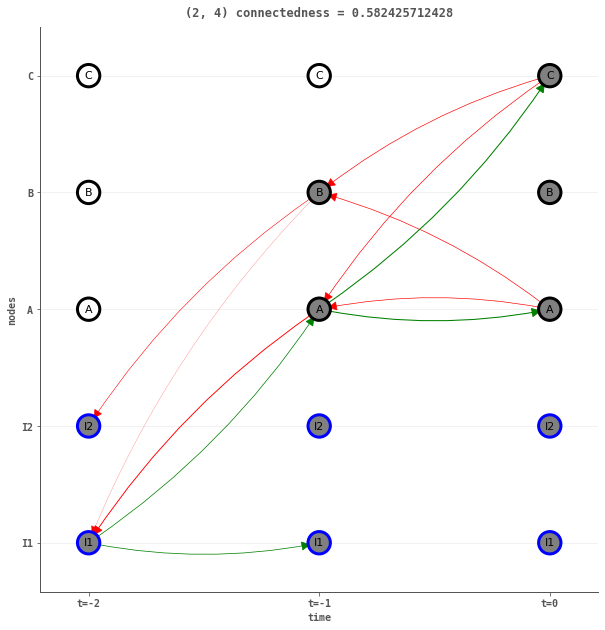

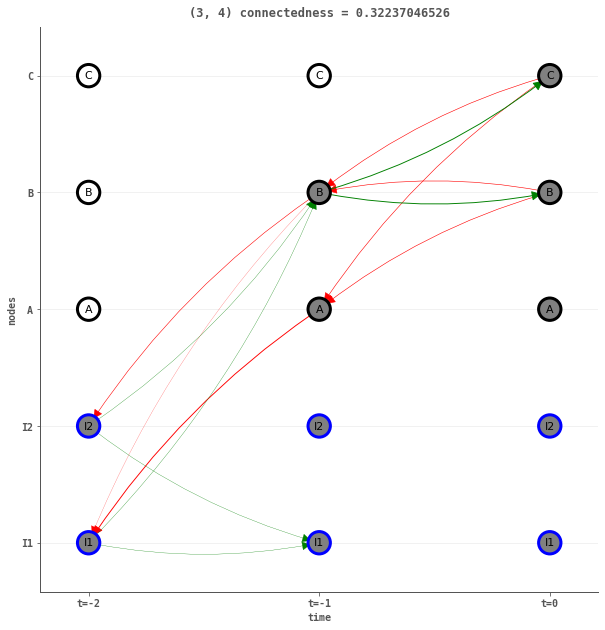

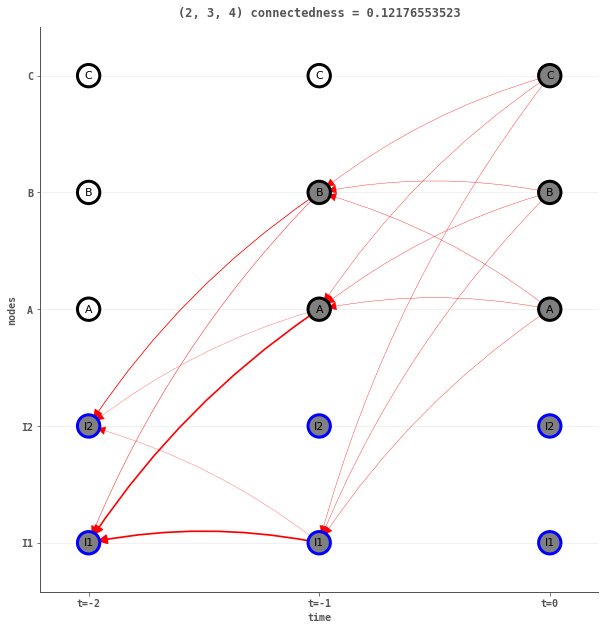

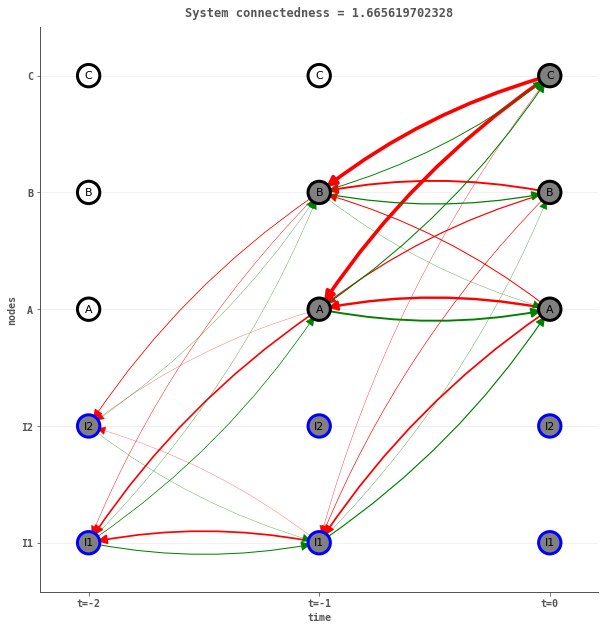

In [16]:
get_all_subset_connectedness(
    network,
    network_states,
    (0, 1),
    (2, 3, 4),
    max_purview_size=4,
    max_mechainsm_size=4,
    start_t=0,
)

# Now based on a "model" object

### Base parameters

In [17]:
LAYER_SIZE = 3

In [18]:
temp = 0.4
field = 0
grid_labels = "ABCDEFGH"

base_params = Params(
    {
        "name": "grid",
        # TODO input layer
        "layers": [
            {
                "layer_name": "input",
                "layer": 0,
                "size": LAYER_SIZE,
                "w_self": 1.0,  # 0.8
                "w_input": 0.2,  # 0.7
                "k_input": 0,
                "w_lateral": 0.01,  # 0.2
                "k_lateral": 1,
                "w_feedback": 0,
                "k_feedback": 0,
                "periodic": False,
                "type": "ising",
                "temp": temp,
                "field": field,
                "labels": ["i" + l for l in grid_labels[:LAYER_SIZE]],
            },
        ]
        + [
            {
                "layer_name": "grid",
                "layer": i,
                "size": LAYER_SIZE,
                "w_self": 1.0,  # 0.8
                "w_input": 0.2,  # 0.7
                "k_input": 1,
                "w_lateral": 0.01,  # 0.2
                "k_lateral": 1,
                "w_feedback": 0,
                "k_feedback": 0,
                "periodic": True,
                "type": "ising",
                "temp": temp,
                "field": field,
                "labels": [f"{l}{i}" for l in grid_labels[:LAYER_SIZE]],
            }
            for i in range(1, 3)
        ],
    }
)

# Detector systems

In [19]:
def add_invariant_detector(params):
    params = params.copy()

    params["layers"].append(
        {
            "layer_name": "INVARIANT",
            "layer": len(params["layers"]),
            "size": 1,
            "start_index": 2,
            "w_lateral": 0,
            "k_lateral": 0,
            "w_feedback": 0,
            "k_feedback": 0,
            "periodic": True,
            "type": "detector",
            "w_lateral": 0,
            "k_lateral": 0,
            "k_input": params["layers"][-1]["size"],
            "w_input": 1.0,
            "patterns": [s for s in pyphi.utils.all_states(LAYER_SIZE) if sum(s) > 0],
            "w_self": 0.005,
            "noise": 0.05,
            "labels": ["OPEN_SOR"],
        }
    )

    params["layers"].append(
        {
            "layer_name": "OUTPUT",
            "layer": len(params["layers"]),
            "size": 1,
            "start_index": 2,
            "w_lateral": 0,
            "k_lateral": 0,
            "w_feedback": 0,
            "k_feedback": 0,
            "periodic": True,
            "type": "copy",
            "w_lateral": 0,
            "k_lateral": 0,
            "k_input": params["layers"][-1]["size"],
            "w_input": 1.0,
            "w_self": 0.1,
            "noise": 0.1,
            "threshold": 0.05,
            "exponent": 10,
            "labels": ["L"],
        }
    )

    return params

## Dot detector

In [20]:
params = deepcopy(base_params)

name = "dot_detector"
params["name"] = name

params["layers"][-1].update(
    {
        "layer_name": name,
        "type": "detector",
        "w_lateral": 0,
        "k_lateral": 0,
        "w_input": 1.0,
        "k_input": 3,
        "patterns": [(0, 1, 0),],
        "w_self": 0.005,
        "noise": 0.05,
    }
)

params = add_invariant_detector(params)

for layer in params["layers"][2:-1]:
    assert layer["noise"] >= 10 * layer["w_self"]

In [21]:
input_state = (0,) * LAYER_SIZE
network_state = (0,) * params.size

model = Model(params, state=network_state)

In [22]:
input_array = (0, 1, 2)
system = (3, 4, 5, 6, 7, 8, 9, 10)
network_states = [
    (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0),
    (0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0),
    (0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0),
    (0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1),
]

In [23]:
detector_bundle = get_system_causal_bundle(
    model,
    network_states,
    input_array,
    system,
    3,
    3,
    start_t=0,
    all_source_subsets=True,
    all_sink_subsets=True,
)

Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/2865280 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/81 [00:00<?, ?it/s]

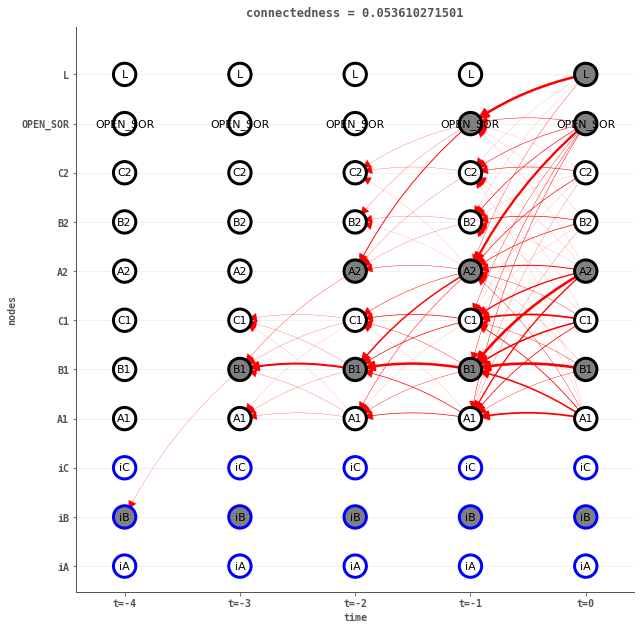

In [24]:
draw_connectedness(model, input_array, system, network_states, detector_bundle)

In [25]:
effects = get_effects_from_source(
    transitions, source_nodes=source_nodes, max_purview_size=4, max_mechanism_size=4,
)

Computing legal effects:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
effects

[[[(0,), (0, 2), 0.307662520635],
  [(1,), (1,), 0.263233125325],
  [(0, 1), (0, 3), 0.090020200944]],
 [[(0, 1), (0, 3), 0.090020200944],
  [(2,), (2, 4), 0.464290801723],
  [(0, 3), (2, 3), 0.091527183223],
  [(1,), (1,), 0.263233125325],
  [(0, 2), (2,), 0.38155600282],
  [(0,), (0, 2), 0.307662520635],
  [(3,), (3, 4), 0.413327747009]]]

In [27]:
input_array = (0, 1, 2)
system = (3, 4, 5, 6, 7, 8, 9, 10)
network_states = [
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
]

transitions = [
    pyphi.actual.Transition(
        model, network_state_1, network_state_2, input_array + system, system
    )
    for network_state_1, network_state_2 in zip(network_states[:-1], network_states[1:])
]

In [28]:
detector_bundle = get_system_causal_bundle(
    model,
    network_states,
    input_array,
    system,
    3,
    3,
    start_t=0,
    all_source_subsets=True,
    all_sink_subsets=True,
)

Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/14776336 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/2401 [00:00<?, ?it/s]

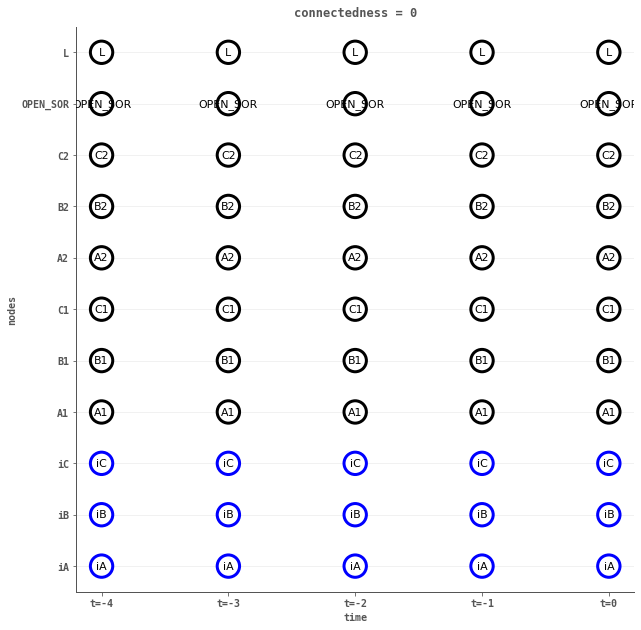

In [29]:
draw_connectedness(model, input_array, system, network_states, detector_bundle)

Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/2401 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/33516 [00:00<?, ?it/s]

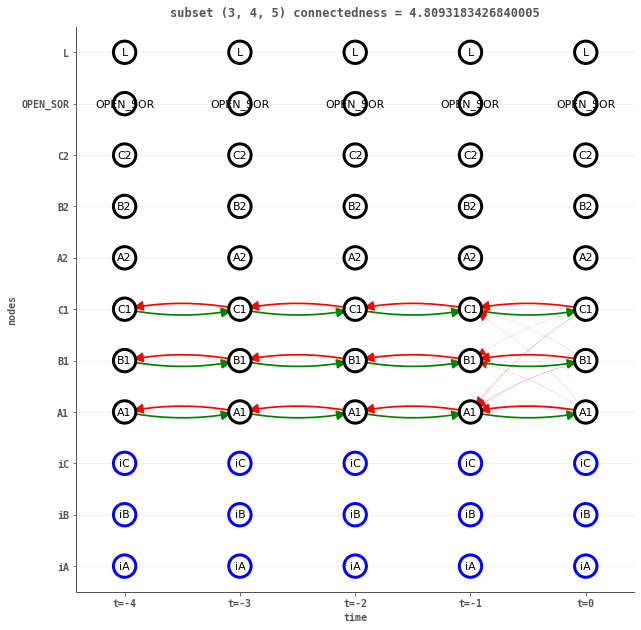

In [34]:
source_nodes = (3,4,5)
sink_nodes = (3,4,5)
bundle = get_system_causal_bundle(
    model,
    network_states,
    source_nodes,
    sink_nodes,
    max_purview_size=4,
    max_mechainsm_size=4,
    start_t=0,
    all_source_subsets=True,
    all_sink_subsets=True,
)
draw_connectedness(model, input_array, system, network_states, bundle,title_prefix='subset {} '.format(sink_nodes))

In [54]:
source_nodes = (3,4)
max_purview_size = 3
max_mechainsm_size = 3
sink_nodes = (3,4)

all_source_subsets = True
all_sink_subsets = True


transitions = [
    pyphi.actual.Transition(
        model,
        network_state_1,
        network_state_2,
        model.node_indices,
        model.node_indices,
    )
    for network_state_1, network_state_2 in zip(
        network_states[:-1], network_states[1:]
    )
]

effects = get_effects_from_source(
    transitions,
    source_nodes=source_nodes,
    max_purview_size=max_purview_size,
    max_mechanism_size=max_mechainsm_size,
)

causes = get_causes_of_sink(
    transitions,
    sink_nodes=sink_nodes,
    max_purview_size=max_purview_size,

    max_mechanism_size=max_mechainsm_size,
)


Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

In [64]:
get_potential_process(causes, effects, transitions, (3,4,5), (3,4,5))

Computing cause chains:   0%|          | 0/192 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/6300 [00:00<?, ?it/s]

{'causes': [[((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114),
   ((3, 4), (5,), 0.002713646161)],
  [((5,), (5,), 0.801553057114),
   ((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114)],
  [((5,), (5,), 0.801553057114),
   ((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114)],
  [((5,), (5,), 0.801553057114),
   ((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114)]],
 'effects': [[((4,), (4,), 0.801553057114), ((3,), (3,), 0.801553057114)],
  [((4,), (4,), 0.801553057114), ((3,), (3,), 0.801553057114)],
  [((4,), (4,), 0.801553057114), ((3,), (3,), 0.801553057114)],
  [((4,), (4,), 0.801553057114), ((3,), (3,), 0.801553057114)]],
 'connectedness': 3.208925874617}

In [62]:
def get_potential_process(causes, effects, transitions, source_nodes, sink_nodes):

    cause_chains = get_cause_chains(
        causes,
        len(transitions),
        source_nodes,
        sink_nodes,
        all_source_subsets=True,
        all_sink_subsets=True,
    )

    effect_chains = get_effect_chains(
        effects,
        0,
        source_nodes,
        sink_nodes,
        all_source_subsets=True,
        all_sink_subsets=True,
    )


    bundled_causes = get_bundled_chains(cause_chains)
    bundled_effects = get_bundled_chains(effect_chains)

    connectedness = sum(
        [get_bundle_strength(bundled_causes), get_bundle_strength(bundled_effects)]
    )

    return {
        "causes": bundled_causes,
        "effects": bundled_effects,
        "connectedness": connectedness,
    }



## Get the causal cone

In [245]:
def get_causal_cone(
    transitions,
    core,
    environment,
    present=None,
    max_purview_size=3,
    max_mechainsm_size=3,
    all_source_subsets=True,
    all_sink_subsets=True,
):

    if present == None:
        present = int(len(transitions) / 2)

    past_transitions = transitions[:present]
    future_transitions = transitions[present:]

    effects_to_core = get_effects_from_source(
        past_transitions,
        source_nodes=environment,
        max_purview_size=max_purview_size,
        max_mechanism_size=max_mechainsm_size,
    )
    causes_of_core = get_causes_of_sink(
        past_transitions,
        sink_nodes=core,
        max_purview_size=max_purview_size,
        max_mechanism_size=max_mechainsm_size,
    )
    effects_of_core = get_effects_from_source(
        future_transitions,
        source_nodes=core,
        max_purview_size=max_purview_size,
        max_mechanism_size=max_mechainsm_size,
    )
    core_as_a_cause = get_causes_of_sink(
        future_transitions,
        sink_nodes=environment,
        max_purview_size=max_purview_size,
        max_mechanism_size=max_mechainsm_size,
    )

    past_effect_chains = get_effect_chains(
        effects,
        0,
        environment,
        core,
        all_source_subsets=True,
        all_sink_subsets=False,
        time_restricted_source=False,
    )
    past_cause_chains = get_cause_chains(
        causes,
        len(past_transitions),
        environment,
        core,
        all_source_subsets=True,
        all_sink_subsets=False,
        time_restricted_source=False,
    )
    future_effect_chains = get_effect_chains(
        effects,
        0,
        core,
        environment,
        all_source_subsets=False,
        all_sink_subsets=True,
        time_restricted_source=True,
    )
    future_cause_chains = get_cause_chains(
        causes,
        len(future_transitions),
        core,
        environment,
        all_source_subsets=False,
        all_sink_subsets=True,
        time_restricted_source=True,
    )

    bundled_past_causes = get_bundled_chains(past_cause_chains)
    bundled_past_effects = get_bundled_chains(past_effect_chains)
    bundled_future_causes = get_bundled_chains(future_cause_chains)
    bundled_future_effects = get_bundled_chains(future_effect_chains)

    connectedness = sum(
        [
            get_bundle_strength(bundled_past_causes),
            get_bundle_strength(bundled_past_effects),
            get_bundle_strength(bundled_future_causes),
            get_bundle_strength(bundled_future_effects),
        ]
    )

    bundled_causes = bundled_future_causes + bundled_past_causes
    bundled_effects = bundled_past_effects + bundled_future_effects

    return {
        "causes": bundled_causes,
        "effects": bundled_effects,
        "connectedness": connectedness,
    }

In [246]:
cone = get_causal_cone(transitions, (2,3), range(5), present=1)

Computing legal effects:   0%|          | 0/1 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/1 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/1 [00:00<?, ?it/s]

Computing legal causes:   0%|          | 0/1 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/252 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/28 [00:00<?, ?it/s]

Computing effect chains:   0%|          | 0/252 [00:00<?, ?it/s]

Computing cause chains:   0%|          | 0/28 [00:00<?, ?it/s]

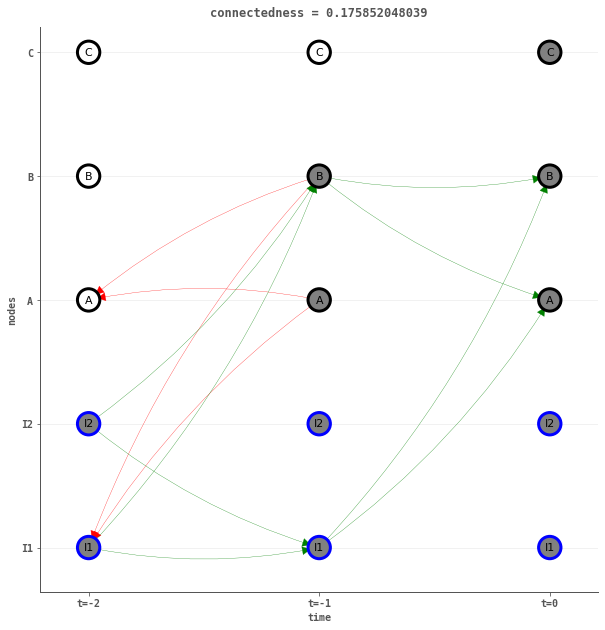

In [247]:
draw_connectedness(network, input_array, system, network_states, cone)

In [248]:
cone

{'causes': [[('NA', 'NA', 0)], [((2, 3), (0, 2), 0.085831847095)]],
 'effects': [[((0, 1), (0, 3), 0.090020200944)],
  [((0, 3), (2, 3), 0.091527183223)],
  [('NA', 'NA', 0)]],
 'connectedness': 0.175852048039}

In [243]:
transitions[1:]

[Transition([I1, I2, A, B, C] ━━▶ [I1, I2, A, B, C])]

## Graveyard

## Trying to plot the connectedness

In [200]:
bundles = {'causes': [[((3, 4), (2, 3), 0.232350264316),
   ((2, 3, 4), (0, 2, 3), 0.12176553523),
   ((4,), (2, 3), 0.959817719408),
   ((2, 3), (0, 2), 0.085831847095),
   ((2,), (0, 2), 0.507998037557),
   ((2, 4), (2, 3), 0.274763191793),
   ((3,), (3,), 0.435179961606)],
  [((3,), (3,), 0.435179961606),
   ((2, 3), (0, 2), 0.085831847095),
   ((2,), (0, 2), 0.507998037557)],
  [((3,), (3,), 0.435179961606), ((2,), (0, 2), 0.507998037557)],
  [((2,), (0,), 0.313529776943), ((3,), (1,), 0.22140573854)]],
 'effects': [[((1,), (3,), 0.19788137882),
   ((0, 1), (3,), 0.085038468485),
   ((0,), (2,), 0.299812849201)],
  [((2,), (2,), 0.448239341226), ((3,), (3,), 0.388942090685)],
  [((2,), (2, 4), 0.464290801723), ((3,), (3, 4), 0.413327747009)],
  [((3, 4), (4,), 0.055945890779),
   ((2, 4), (4,), 0.055945890779),
   ((2,), (2, 4), 0.464290801723),
   ((4,), (4,), 0.162555971357),
   ((3,), (3, 4), 0.413327747009)]],
 'connectedness': 0.582732696506}

In [23]:
input_array = (0, 1)
system = (2, 3, 4)
network_states = [
    (1, 1, 0, 0, 0),
    (1, 1, 0, 0, 0),
    (1, 1, 1, 1, 0),
    (1, 1, 1, 1, 0),
    (1, 1, 1, 1, 1),
    (1, 1, 1, 1, 1),
]

In [236]:
def draw_connectedness(network, input_array, system, network_states, causal_bundle):
    # define network
    G = nx.DiGraph()

    # define nodes
    node_states = []
    border_color = []
    node_position = dict()
    node_label = []
    for t in range(len(network_states)):
        for i in input_array + system:
            node_name = network.node_labels[i] + " " + str(t)
            node_label.append(node_name)
            node_states.append("gray" if network_states[t][i] == 1 else "w")
            border_color.append("k" if i in system else "b")
            node_position[node_name] = (t, i)
            G.add_node(node_name)

    # define edges
    edge_colors = []
    edge_styles = []
    edge_labels = []
    edge_widths = dict()
    counter = 0
    for direction, bundle in bundles.items():
        if not direction == "connectedness":
            for t, links in enumerate(bundle):
                if direction == "causes":
                    for link in links:
                        mechanism = link[0]
                        purview = link[1]
                        alpha = link[2]

                        for m in mechanism:
                            for p in purview:
                                source = (
                                    network.node_labels[m]
                                    + " "
                                    + str(len(network_states) - 1 - (t))
                                )
                                target = (
                                    network.node_labels[p]
                                    + " "
                                    + str(len(network_states) - 1 - (t + 1))
                                )
                                a = 0.11 + 2 * alpha

                                if not (source, target) in edge_widths.keys():
                                    edge_colors.append("r")
                                    edge_widths[(source, target)] = a
                                    edge_labels.append((source, target))
                                else:
                                    edge_widths[(source, target)] += a

                if direction == "effects":
                    for link in links:
                        mechanism = link[0]
                        purview = link[1]
                        alpha = link[2]

                        for m in mechanism:
                            for p in purview:
                                source = network.node_labels[m] + " " + str((t))
                                target = network.node_labels[p] + " " + str((t + 1))
                                a = 0.11 + 2 * alpha

                                if not (source, target) in edge_widths.keys():
                                    edge_colors.append("g")
                                    edge_widths[(source, target)] = a
                                    edge_labels.append((source, target))
                                else:
                                    edge_widths[(source, target)] += a
    G.add_edges_from(edge_labels)

    fig, ax = plt.subplots(figsize=(10,10))

    nx.draw_networkx_nodes(
        G,
        node_position,
        node_color=node_states,
        node_size=500,
        node_shape="o",
        label=node_label,
        edgecolors=border_color,
        linewidths=3, ax=ax
    )

    nx.draw_networkx_edges(
        G,
        node_position,
        edgelist=edge_labels,
        width=list(edge_widths.values()),
        edge_color=edge_colors,
        arrowstyle="-|>",
        arrowsize=20,
        connectionstyle="arc3,rad=0.1", ax=ax
    )

    
    nx.draw_networkx_labels(G, node_position, {l: l[:-2] for l in node_label}, font_size=11, ax=ax)

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.title("System connectedness = {}".format(causal_bundle["connectedness"]))

    plt.xticks(
        ticks=list(range(len(network_states[0])+1)),
        labels=["t={}".format(-(len(network_states[0])-t)) for t in range(len(network_states[0])+1)],
    )
    plt.yticks(ticks=list(range(len(network))), labels=network.node_labels)
    plt.xlabel("time")
    plt.ylabel("nodes")
    return G

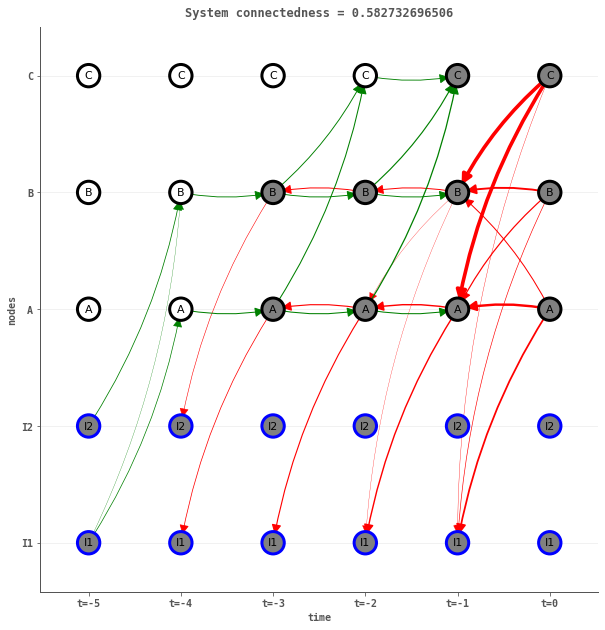

In [237]:
draw_connectedness(network, input_array, system, network_states, bundles)

In [186]:
["t={}".format(-t) for t in range(len(network_states[0]))]

['t=0', 't=-1', 't=-2', 't=-3', 't=-4']

In [125]:
list(G.edges())[:counter]

[('I1 0', 'B 1'),
 ('I1 0', 'A 1'),
 ('I2 0', 'B 1'),
 ('A 1', 'A 2'),
 ('B 1', 'B 2'),
 ('A 2', 'I1 1'),
 ('A 2', 'A 3'),
 ('A 2', 'C 3'),
 ('B 2', 'I2 1'),
 ('B 2', 'B 3'),
 ('B 2', 'C 3'),
 ('A 3', 'I1 2'),
 ('A 3', 'A 2'),
 ('A 3', 'C 4'),
 ('A 3', 'A 4'),
 ('B 3', 'B 2'),
 ('B 3', 'C 4'),
 ('B 3', 'B 4'),
 ('C 3', 'C 4'),
 ('A 4', 'I1 3'),
 ('A 4', 'A 3'),
 ('B 4', 'B 3'),
 ('B 4', 'I1 3'),
 ('B 4', 'A 3'),
 ('A 5', 'I1 4'),
 ('A 5', 'A 4'),
 ('A 5', 'B 4'),
 ('B 5', 'A 4'),
 ('B 5', 'B 4'),
 ('B 5', 'I1 4'),
 ('C 5', 'A 4'),
 ('C 5', 'B 4'),
 ('C 5', 'I1 4')]

In [126]:
counter

38

In [127]:
len(G.edges())

33

## Generalizing functions

In [10]:
account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.EFFECT,
            mechanisms=past_sink_subsets + source_subsets,
            purviews=list(
                pyphi.utils.powerset(
                    sink_nodes, nonempty=True, max_size=max_purview_size
                )
            ),
            allow_neg=False,
        )

5

In [35]:
def get_effects_from_source(
    transitions,
    source_nodes=None,
    max_purview_size=5,
    max_mechanism_size=5,
):

    if source_nodes == None:
        source_nodes = range(len(transitions[0].network))

    source_subsets = list(
        pyphi.utils.powerset(source_nodes, nonempty=True, max_size=max_mechanism_size)
    )
    
    all_purviews = list(
                pyphi.utils.powerset(
                    range(len(transitions[0].network)), nonempty=True, max_size=max_purview_size
                )
    )

    past_effect_subsets = []
    effects = []

    # loop through all transitions
    for i, t in enumerate(tqdm(transitions, desc="Computing legal effects")):

        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.EFFECT,
            mechanisms=set(past_effect_subsets + source_subsets),
            purviews=all_purviews,
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        effects.append(
            [
                [effect.mechanism, effect.purview, effect.alpha]
                for effect in account.irreducible_effects
            ]
        )

        # updating which sink_nodes subsets will be used as mechanisms in the next iteration.
        # only those that are completely contained in a an actual effect from this iteration.
        past_effect_subsets = [
            mechanism_subset
            for mechanism_subset in all_purviews
            if any(
                [
                    all([element in effect.purview for element in mechanism_subset])
                    for effect in account.irreducible_effects
                ]
            )
        ]
    return effects

In [46]:
def get_causes_of_sink(
    transitions, 
    sink_nodes=None,
    max_purview_size=5,
    max_mechanism_size=5,
):

    if sink_nodes == None:
        sink_nodes = range(len(transitions[0].network))

    sink_subsets = list(
        pyphi.utils.powerset(sink_nodes, nonempty=True, max_size=max_mechanism_size)
    )
    
    all_subsets = list(
        pyphi.utils.powerset(range(len(transitions[0].network)), nonempty=True, max_size=max_mechanism_size)
    )
    
    past_cause_subsets = []
    causes = []
    # loop through all transitions
    for i, t in enumerate(tqdm(reversed(transitions), total=len(transitions), desc= "Computing legal causes")):
        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.CAUSE,
            mechanisms=set(past_cause_subsets+sink_subsets),
            purviews=all_subsets,
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        causes.append(
            [
                [cause.mechanism, cause.purview, cause.alpha]
                for cause in account.irreducible_causes
            ]
        )
        
        # updating which sink_nodes subsets will be used as mechanisms in the next iteration.
        # only those that are completely contained in a an actual effect from this iteration.
        past_cause_subsets = [
            mechanism_subset
            for mechanism_subset in all_subsets
            if any(
                [
                    all([element in effect.purview for element in mechanism_subset])
                    for effect in account.irreducible_causes
                ]
            )
        ]

    return causes

In [63]:
effects = get_effects_from_source(
    transitions,
    source_nodes=None,
    max_purview_size=5,
    max_mechanism_size=5,
)

Computing legal effects:   0%|          | 0/5 [00:00<?, ?it/s]

In [85]:
e_chains = get_effect_chains(
    effects, 0, 4, (0,1), (3,4,), all_subsets=True
)
e_chains

NameError: name 'mechanisms' is not defined

In [77]:
effects

[[[(2,), (2, 4), 0.579586092273],
  [(3, 4), (4,), 0.256458545688],
  [(0, 2), (1,), 0.076743204398],
  [(0, 2, 4), (1, 4), 0.074824624288],
  [(0, 1, 2, 4), (0, 4), 0.153875127413],
  [(4,), (4,), 0.1550355592],
  [(1,), (1,), 0.263233125325],
  [(0, 2, 3, 4), (0, 3, 4), 0.020660866205],
  [(0, 1, 2), (0, 1), 0.1893847722],
  [(1, 2, 4), (1, 2, 4), 0.097410175441],
  [(0, 1), (0, 1), 0.076001546723],
  [(2, 4), (4,), 0.256458545688],
  [(1, 2), (1, 2), 0.099907872247],
  [(0, 2, 3), (0, 3), 0.037206596201],
  [(0,), (0,), 0.263233125325],
  [(3,), (3, 4), 0.526754519123],
  [(2, 3), (2, 3), 0.122781767463],
  [(2, 3, 4), (2, 3, 4), 0.092411768783]],
 [[(2,), (4,), 0.284328257734],
  [(3, 4), (4,), 0.256458545688],
  [(0, 2), (1,), 0.076743204398],
  [(0, 2, 4), (1, 4), 0.074824624288],
  [(0, 1, 2, 4), (0, 4), 0.153875127413],
  [(4,), (4,), 0.1550355592],
  [(1,), (1,), 0.263233125325],
  [(0, 1, 2), (0, 1), 0.1893847722],
  [(1, 2, 4), (3, 4), 0.082912506773],
  [(0, 1), (0, 3), 0.0

In [48]:
get_causes_of_sink(
    transitions, 
    sink_nodes=(4,),
    max_purview_size=5,
    max_mechanism_size=5,
)

Computing legal causes:   0%|          | 0/5 [00:00<?, ?it/s]

[[[(4,), (2, 3), 0.959817719408]],
 [[(2, 3), (0, 2), 0.085831847095],
  [(2,), (0, 2), 0.507998037557],
  [(3,), (3,), 0.435179961606],
  [(4,), (2, 3), 0.959817719408]],
 [[(2,), (0, 2), 0.507998037557],
  [(4,), (4,), 0.12159651702],
  [(2, 3), (0, 2), 0.085831847095],
  [(0, 2), (0,), 0.182595676573],
  [(0,), (0,), 0.438721875541],
  [(3,), (3,), 0.435179961606]],
 [[(2,), (0,), 0.313529776943],
  [(4,), (2, 4), 0.234373511752],
  [(0, 2), (0,), 0.182595676573],
  [(0,), (0,), 0.438721875541],
  [(3,), (1,), 0.22140573854]],
 [[(2, 4), (2,), 0.141648703355],
  [(2,), (2,), 0.4235988636],
  [(4,), (2, 4), 0.234373511752],
  [(1,), (1,), 0.438721875541],
  [(0,), (0,), 0.438721875541]]]

In [16]:
def get_legal_effects(
    transitions, input_array, system, max_purview_size=5, max_mechanism_size=5
):
    input_subsets = list(pyphi.utils.powerset(input_array, nonempty=True, max_size=max_mechanism_size))
    past_system_subsets = []
    effects = []

    # loop through all transitions
    for i, t in enumerate(tqdm(transitions, desc= "Computing legal effects")):
        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.EFFECT,
            mechanisms=past_system_subsets + input_subsets,
            purviews=list(pyphi.utils.powerset(system, nonempty=True, max_size=max_purview_size)),
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        effects.append(
            [
                [effect.mechanism, effect.purview, effect.alpha]
                for effect in account.irreducible_effects
            ]
        )

        # updating which system subsets will be used as mechanisms in the next iteration.
        # only those that are completely contained in a an actual effect from this iteration.
        past_system_subsets = [
            mechanism_subset
            for mechanism_subset in pyphi.utils.powerset(system, nonempty=True)
            if any(
            [
                all([element in effect.purview for element in mechanism_subset])
                for effect in account.irreducible_effects
            ]
        )

        ]

        '''
        if all([mech_element in set([element for effect in account.irreducible_effects for element in effect.purview]) for mech_element in mechanism_subset])
        '''

    return effects

In [163]:
effects = get_effects_of_source(transitions, input_array, system)
effects

NameError: name 'get_effects_of_source' is not defined

In [8]:
def get_legal_causes(
    transitions, input_array, system, max_purview_size=5, max_mechanism_size=5
):
    system_subsets = list(pyphi.utils.powerset(system, nonempty=True, max_size=max_mechanism_size))
    all_subsets = list(pyphi.utils.powerset(input_array+system, nonempty=True, max_size=max_purview_size))
    causes = []
    # loop through all transitions
    for i, t in enumerate(tqdm(reversed(transitions), total=len(transitions), desc= "Computing legal causes")):
        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.CAUSE,
            mechanisms=system_subsets,
            purviews=all_subsets,
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        causes.append(
            [
                [cause.mechanism, cause.purview, cause.alpha]
                for cause in account.irreducible_causes
            ]
        )

    return causes
    # NOTE: Think about the implementation for selecting the "legal" next mechanisms

In [144]:
causes = get_legal_causes(transitions, input_array, system,3,3)
causes

Computing legal causes:   0%|          | 0/5 [00:00<?, ?it/s]

[[[(2,), (0, 2), 0.507998037557],
  [(3,), (3,), 0.435179961606],
  [(4,), (2, 3), 0.959817719408],
  [(2, 3), (0, 2), 0.085831847095],
  [(2, 4), (2, 3), 0.274763191793],
  [(3, 4), (2, 3), 0.232350264316],
  [(2, 3, 4), (0, 2, 3), 0.12176553523]],
 [[(2,), (0, 2), 0.507998037557],
  [(3,), (3,), 0.435179961606],
  [(4,), (2, 3), 0.959817719408],
  [(2, 3), (0, 2), 0.085831847095],
  [(2, 4), (2, 3), 0.274763191793],
  [(3, 4), (2, 3), 0.232350264316],
  [(2, 3, 4), (0, 2, 3), 0.12176553523]],
 [[(2,), (0, 2), 0.507998037557],
  [(3,), (3,), 0.435179961606],
  [(4,), (4,), 0.12159651702],
  [(2, 3), (0, 2), 0.085831847095]],
 [[(2,), (0,), 0.313529776943],
  [(3,), (1,), 0.22140573854],
  [(4,), (2, 4), 0.234373511752],
  [(2, 3), (0,), 0.038930357701],
  [(3, 4), (1, 2), 0.070275550281]],
 [[(2,), (2,), 0.4235988636],
  [(3,), (3,), 0.340888442247],
  [(4,), (2, 4), 0.234373511752],
  [(2, 3), (3,), 0.060898712266],
  [(2, 4), (2,), 0.141648703355],
  [(3, 4), (3,), 0.160246489913],


In [10]:
def get_actual_chains(effects):

    # list all potential chains through the system (based on causal links)
    potential_chains = [chain for chain in product(*[range(len(links)) for links in effects])]
    possible_chains = []
    chain_alphas = []
    
    tau = len(potential_chains[0])

    # loop through every potential chain
    for chain in potential_chains:

        # starting from all possible time points
        for start_t in range(tau):
            possible = True

            # check that the first mechanism is completely in the input array
            first_mechanism = effects[start_t][chain[start_t]][0]
            if all([element in input_array for element in first_mechanism]):

                # get the effect purview of the first mechanism given the potential chain
                effect_purview = effects[start_t][chain[start_t]][1]

                # loop through the remainder of the time
                # only allowing direct effects on the last link
                if start_t<tau-1:
                    # get the next mechanism given the potential chain
                    next_mechanism = effects[start_t + 1][chain[start_t + 1]][0]
                    for t in range(start_t, tau-1):
                        effect_purview = effects[t][chain[t]][1]
                        next_mechanism = effects[t + 1][chain[t + 1]][0]

                        # if not all elements in the next mechanism is in the current effect, the chain is broken
                        if not all([element in effect_purview for element in next_mechanism]):
                            possible = False
                            break
                    

                # store the possible chains with their respective alpha values
                if possible:
                    possible_chain = [()]*start_t + [effects[start_t][chain[start_t]][0]] + [
                        effect[link][1]
                        for effect, link in zip(effects[start_t:], chain[start_t:])
                    ]
                    chain_alpha = [np.nan]*(start_t) + [
                        effect[link][2]
                        for effect, link in zip(effects[start_t:], chain[start_t:])
                    ]

                    # but keep only unique chains
                    if not any([possible_chain == p for p in possible_chains]):
                        possible_chains.append(possible_chain)
                        chain_alphas.append(chain_alpha)
    
    return {tuple(possible_chain): chain_alpha for possible_chain, chain_alpha in zip(possible_chains, chain_alphas)}

def get_chains_to_subset(actual_chains, subset):
    ### Organizing the causal chains by the subset that they end up on 
    # NOTE: This manner is very inclusive, but seems most consistent with the rest
    chains_to_subsets = [
            [possible_chain, chain_alpha]
            for possible_chain, chain_alpha in actual_chains.items()
            if all([element in possible_chain[-1] for element in subset])
        ]   
    return chains_to_subsets

In [11]:
actual_chains = get_actual_chains(effects)

In [ ]:

cause_chains = get_cause_chains(causes, 0, len(transitions), system, input_array, all_subsets=True)
effect_chains = get_effect_chains(effects, 0, len(transitions), input_array, system, all_subsets=True)

In [133]:
cause_chains

[]

In [ ]:
G = nx.DiGraph()

effects = []
pos = dict()
for x, chain in enumerate(actual_chains):
    y_effect = 0
    for y, link in enumerate(chain):
        cause_name = str(link[0])+' '+str(x)
        cause_pos = (x,y)
        G.add_node(cause_name, pos=cause_pos)
        pos[cause_name] = cause_pos
        if str(link[1])+' '+str(x+1) not in effects:
            effect_name = str(link[1])+' '+str(x+1)
            effect_pos = (x+0.7,y_effect)
            G.add_node(effect_name, pos=effect_pos)
            y_effect += 1
            pos[effect_name] = effect_pos

In [314]:
import networkx as nx

G = nx.DiGraph()

effects = []
pos = dict()
for x, chain in enumerate(actual_chains):
    y_effect = 0
    for y, link in enumerate(chain):
        cause_name = str(link[0])+' '+str(x)
        cause_pos = (x,y)
        G.add_node(cause_name, pos=cause_pos)
        pos[cause_name] = cause_pos
        if str(link[1])+' '+str(x+1) not in effects:
            effect_name = str(link[1])+' '+str(x+1)
            effect_pos = (x+0.7,y_effect)
            G.add_node(effect_name, pos=effect_pos)
            y_effect += 1
            pos[effect_name] = effect_pos
            
links = [(str(link[0])+' '+str(t), str(link[1])+' '+str(t+1), link[2]) for t,chain in enumerate(actual_chains) for link in chain]
mechanisms = []
for t, chain in enumerate(actual_chains):
    for link1 in chain:
        for link2 in chain:
            if (not link1 == link2) and all([element in link2[0] for element in link1[0]]):
                mechanisms.append((str(link1[0])+' '+str(t), str(link2[0])+' '+str(t), -1))

G.add_weighted_edges_from(links)
#G.add_weighted_edges_from(mechanisms,style='dashed',edge_color='r')

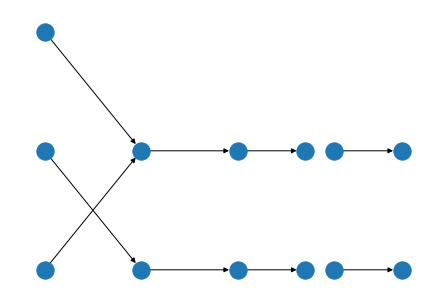

In [315]:

nx.draw(G, pos)   # default spring_layout

In [306]:
draw_networkx_edges(
    G,
    pos,
    edgelist=None,
    width=1.0,
    edge_color="k",
    style="solid",
    alpha=None,
    arrowstyle="-|>",
    arrowsize=10,
    edge_cmap=None,
    edge_vmin=None,
    edge_vmax=None,
    ax=None,
    arrows=None,
    label=None,
    node_size=300,
    nodelist=None,
    node_shape="o",
    connectionstyle="arc3",
    min_source_margin=0,
    min_target_margin=0,
)

## Attempting Shapley trickery

In [104]:

# Todo: The shapley values of the individual nodes should sum to the alpha of the purview as a whole.
# That is true, but only up to 10^-4 because of rounding in pyphi I assume.

def compute_shapley_values(CausalLink, transition):

    # get the purview elements of the causal link
    purview = CausalLink.purview
    
    # Make a dict of the alpha values of the powerset of purview elements for the causal link
    alpha_dict = {
        p: transition.find_mip(CausalLink.direction,CausalLink.mechanism, p).alpha 
        for p in pyphi.utils.powerset(CausalLink.purview)
    }
    print(alpha_dict)
    
    # compute shapley value alphas for each node in the purview
    shapley_values = np.zeros((len(purview)))
    for i,node in enumerate(purview):
        complement_set = tuple(sorted(set(purview) - set([node])))

        shapley = 0.
        # cycle through all permutations of the other nodes in the purview
        for p in pyphi.utils.powerset(complement_set):

            delta_alpha = alpha_dict[tuple(sorted(set(p).union(set([node]))))] - alpha_dict[p]

            # sum up the node's contribution to cause for every possible permutation
            shapley = shapley + shapley_factor(p,purview) * delta_alpha

        # save shapley alpha value for that node
        shapley_values[i] = shapley
        
    return shapley_values


def shapley_factor(S, F):
    # (|S|! (|F| - |S| - 1)!)/F!
    factor = factorial(len(S))*factorial(len(F)-len(S)-1)/factorial(len(F))
    return factor

In [100]:
from math import factorial
#import pdb; pdb.set_trace() 

def get_legal_shapley_effects(
    transitions, input_array, system,
):
    input_subsets = list(pyphi.utils.powerset(input_array, nonempty=True))
    past_system_subsets = []
    effects = []

    # loop through all transitions
    for i, t in enumerate(transitions):
        # compute the directed account for all valid mechansisms over all system subsets
        account = pyphi.actual.directed_account(
            t,
            pyphi.direction.Direction.EFFECT,
            mechanisms=past_system_subsets + input_subsets,
            purviews=list(pyphi.utils.powerset(system, nonempty=True)),
            allow_neg=False,
        )
        # NOTE: Here negative alpha are not allowed (negative connectedness could still be possible depending on later definitions)

        # adding necessary variables to the growing list of effects
        effects.append(
            [
                [effect.mechanism, effect.purview, effect.alpha]
                for effect in account.irreducible_effects
            ]
        )

        # updating which system subsets will be used as mechanisms in the next iteration.
        # only those that are completely contained in a an actual effect from this iteration.
        past_system_subsets = [
            mechanism_subset
            for mechanism_subset in pyphi.utils.powerset(system, nonempty=True)
            if any(
                [
                    all([element in effect.purview for element in mechanism_subset])
                    for effect in account.irreducible_effects
                ]
            )
        ]

    return effects

In [101]:
account = pyphi.actual.directed_account(
            transitions[3],
            pyphi.direction.Direction.EFFECT,
            mechanisms=past_system_subsets + input_subsets,
            purviews=list(pyphi.utils.powerset(system, nonempty=True)),
            allow_neg=False,
        )

In [105]:
compute_shapley_values(account[0], transitions[3])

{(): 0.0, (2,): 0.543972493101, (4,): 0.431248238125, (2, 4): 0.630461344492}


array([0.3715928 , 0.25886854])

In [103]:
account[0]

CausalLink
  α = 0.6305  [A] ━━▶ [A, C]

# Theres an issue where the direct effect in the last link is not counted. 
# Is it just that it is miscoded? 

In [80]:
chains_to_subsets = get_actual_chains(effects)


In [82]:
chains_to_subsets[(2,)]

[[[(0,), (2,)], [0.205646490908]],
 [[(0,), (2,), (2, 4)], [0.205646490908, 0.630461344492]],
 [[(0,), (2,), (2, 4), (2, 4)],
  [0.205646490908, 0.630461344492, 0.630461344492]],
 [[(0,), (2,), (2,), (2, 4), (2, 4)],
  [0.205646490908, 0.543972493101, 0.630461344492, 0.630461344492]]]

In [57]:
possible_chain = [(2,3,), (2,)]
subset = (2,)

all([element in possible_chain[-1] for element in subset])

True

In [58]:
effects

[[[(1,), (2,), 0.041761677781]],
 [[(2,), (4,), 0.3704491924],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]],
 [[(2,), (2,), 0.543972493101],
  [(3,), (3,), 0.484029254105],
  [(4,), (4,), 0.018188264998],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]],
 [[(2,), (2, 4), 0.630461344492],
  [(3,), (3, 4), 0.573536710111],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]],
 [[(2,), (2, 4), 0.630461344492],
  [(3,), (3, 4), 0.573536710111],
  [(4,), (4,), 0.018437472008],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]]]

In [59]:
chains_to_subsets

{(2,): [[[(0,), (2,), (2, 4)], [0.205646490908, 0.630461344492]],
  [[(0,), (2,), (2, 4), (2, 4)],
   [0.205646490908, 0.630461344492, 0.630461344492]],
  [[(0,), (2,), (2,), (2, 4), (2, 4)],
   [0.205646490908, 0.543972493101, 0.630461344492, 0.630461344492]]],
 (3,): [[[(1,), (3,), (3, 4)], [0.110856020795, 0.573536710111]],
  [[(0, 1), (3,), (3, 4)], [0.085038468485, 0.573536710111]],
  [[(1,), (3,), (3, 4), (3, 4)],
   [0.110856020795, 0.573536710111, 0.573536710111]],
  [[(0, 1), (3,), (3, 4), (3, 4)],
   [0.085038468485, 0.573536710111, 0.573536710111]],
  [[(1,), (3,), (3,), (3, 4), (3, 4)],
   [0.110856020795, 0.484029254105, 0.573536710111, 0.573536710111]],
  [[(0, 1), (3,), (3,), (3, 4), (3, 4)],
   [0.085038468485, 0.484029254105, 0.573536710111, 0.573536710111]]],
 (4,): [[[(0,), (2,), (2, 4)], [0.205646490908, 0.630461344492]],
  [[(1,), (3,), (3, 4)], [0.110856020795, 0.573536710111]],
  [[(0, 1), (3,), (3, 4)], [0.085038468485, 0.573536710111]],
  [[(0,), (2,), (2, 4), 

In [28]:
effects

[[[(1,), (2,), 0.041761677781]],
 [[(2,), (4,), 0.3704491924],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]],
 [[(2,), (2,), 0.543972493101],
  [(3,), (3,), 0.484029254105],
  [(4,), (4,), 0.018188264998],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]],
 [[(2,), (2, 4), 0.630461344492],
  [(3,), (3, 4), 0.573536710111],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]],
 [[(2,), (2, 4), 0.630461344492],
  [(3,), (3, 4), 0.573536710111],
  [(4,), (4,), 0.018437472008],
  [(0,), (2,), 0.205646490908],
  [(1,), (3,), 0.110856020795],
  [(0, 1), (3,), 0.085038468485]]]

### Among all possible chains to a subset, pick out the one that maximizes the so-called "total_chain_alpha"
The total chain alpha is defined in a way that is inspired by phi formulation
- Informativeness: the maximal "minimum alpha along the chain" over average "minimum alpha along the chain" across all possible chains
- Selectivity: the maximal "minimum alpha along the chain" over the maximal possible "minimum alpha along the chain" for that particular chain (defined as the sum of the purview sizes, assuming maximal alpha of one ibit pr purview element) 

In [117]:
actual_chain = {}

# looping through all connected subsets
for subset, possible_chain_to_subsets in chains_to_subsets.items():
    min_alphas = []
    max_possible_alphas = []

    # looping through all the possible chains from the inputs to the subset
    for possible_chain_to_subset in possible_chain_to_subsets:
        # finding the minimal alpha along the chain
        min_alphas.append(min(possible_chain_to_subset[1]))
        # and computing the maximal possible alpha along that same chain
        max_possible_alphas.append(
            sum([len(purview) for purview in possible_chain_to_subset[0][1:]])
        )

    # picking the chain that has the highest "total_chain_alpha"
    if len(possible_chain_to_subsets) > 0:
        total_chain_alpha = [
            (
                (min_alpha / max_possible_alpha)
                * np.log2(min_alpha / np.mean(min_alphas))
            )
            for min_alpha, max_possible_alpha in zip(min_alphas, max_possible_alphas)
        ]

        max_chain = np.argmax(total_chain_alpha)
        actual_chain[subset] = [
            possible_chain_to_subsets[max_chain][0],
            total_chain_alpha[max_chain],
            "tied: {}".format(sum(total_chain_alpha == total_chain_alpha[max_chain]) > 1),
        ]

### Print the actual chain to every connected system subset, with their respective total_chain_alpha

In [118]:
actual_chain

{(2,): [[(0,), (2,), (2,)], 0.15136337537668004, 'tied: False'],
 (3,): [[(0,), (2,), (3,)], 0.04464955708774822, 'tied: True'],
 (4,): [[(0,), (2,), (4,)], 4.6173612373999104e-05, 'tied: True'],
 (2, 4): [[(0,), (2,), (3, 4), (2, 4)], 0.06433529379235296, 'tied: False'],
 (3, 4): [[(0,), (2,), (3, 4)], 0.09497168510169228, 'tied: False']}

## OLD VERSION

### Compute all effect information values between all subsets for every transition
I include the input array in the "past" for every transition, so that we can allow the connectedness from input to subset to be "staggered". By that I mean that the strongest effect of the input over some subset, may be for a shorter delay than tau. I think we should allow that.

In [ ]:
effects = {
    i: {
        input_subset: {
            system_subset: transition.find_causal_link(
                pyphi.direction.Direction.EFFECT,
                input_subset,
                purviews=[system_subset],
                allow_neg=True,
            ).alpha  # effect_ratio(input_subset, system_subset)
            for system_subset in pyphi.utils.powerset(system, nonempty=True)
        }
        for input_subset in pyphi.utils.powerset(input_array + system, nonempty=True)
    }
    for i, transition in enumerate(transitions)
}

In [ ]:
effects

### Finding all chains from an input_subset to the system subset in tau steps, and storing the associated rho values
I wasn't able to generalize to the staggered version yet. But I think it shouldn't be very difficult. 


possible chains take the following form:
[input_subset, (one out of the system mechanisms)*(tau-1), system_subset]


In [ ]:
tau = len(network_states) - 1


system_subsets = list(pyphi.utils.powerset(system, nonempty=True))
alphas = {
    tuple(chain): [
        effect_infos[i][cause][effect]
        for i, (cause, effect) in enumerate(zip(chain[:-1], chain[1:]))
    ]
    for input_subset in pyphi.utils.powerset(input_array, nonempty=True)
    for system_subset in pyphi.utils.powerset(system, nonempty=True)
    for chain in [[input_subset] + list(chain) + [system_subset] for chain in list(product(*[system_subsets]*(tau-1)))]
}
        

# computing some derivative values that I think are useful for getting at the "total indirect effect"
Currently I like the signed product. This is because I think doing just the min is too simple--if two chains have the same min, but one has a lot of strong effects elsewhere but the other has just barely stronger effects in the rest of the chain, I think the former should "win" somehow. 

In [ ]:
df = pd.DataFrame(alphas).transpose()

df['min'] = df.min(axis=1)
df['prod'] = df.apply(lambda row: np.prod(np.abs(row)), axis=1)
df['sign'] = df.apply(lambda row: -1 if min(row)<0 else 1, axis=1)
df['prod_sign'] = df[["prod", "sign"]].product(axis=1)


### Picking out the maximal chains for each input_subset - system_subset pair
The "groupby functionality was bugging for me (probably because I use tuples as indexes), So I did it in this way instead. Below is the same but for only oundting each system_subset once.

In [ ]:
chains = {
    chain: effect
    for chain, effect in zip(
        df.groupby(level=[0,-1])["prod_sign"].idxmax().values,
        df.groupby(level=[0,-1])["prod_sign"].max(),
    )
}
chains

In [ ]:
chains = {
    chain: effect
    for chain, effect in zip(
        df.groupby(level=[-1])["prod_sign"].idxmax().values,
        df.groupby(level=[-1])["prod_sign"].max(),
    )
}
chains

In [ ]:

df_max = df["prod_sign"].groupby(level=[0,-1]).max()

df_max

In [ ]:
df_max.groupby(level=[-1]).max()

In [ ]:
df["prod_sign"].groupby(level=[-1]).max()

In [ ]:
df.loc[df.groupby(level=[-1])["prod_sign"].idxmax()]

In [ ]:
df.groupby(level=[-1])["prod_sign"].idxmax()

In [ ]:
chains = {
    chain: effect
    for chain, effect in zip(
        df.groupby(level=[-1])["prod_sign"].idxmax().values,
        df.groupby(level=[-1])["prod_sign"].max(),
    )
}
chains

In [ ]:
df.groupby(level=[-1])["prod_sign"].max()

# Now based on a "model" object

### Base parameters

In [52]:
LAYER_SIZE = 3

In [53]:
temp = 0.4
field = 0
grid_labels = 'ABCDEFGH'

base_params = Params({
    "name": "grid",
    # TODO input layer
    "layers": [
        {
            "layer_name": "input",
            "layer": 0,
            "size": LAYER_SIZE,
            'w_self': 1.0, # 0.8
            'w_input': 0.2, # 0.7
            "k_input": 0,
            'w_lateral': 0.01, # 0.2
            "k_lateral": 1,
            "w_feedback": 0,
            "k_feedback": 0,
            "periodic": False,
            "type": "ising",
            "temp": temp,
            "field": field,
            "labels": ['i' + l for l in grid_labels[:LAYER_SIZE]],
        },
    ]+  [
        {
            "layer_name": 'grid',
            "layer": i,
            "size": LAYER_SIZE,
            'w_self': 1.0, # 0.8
            'w_input': 0.2, # 0.7
            "k_input": 1,
            'w_lateral': 0.01, # 0.2
            "k_lateral": 1,
            "w_feedback": 0,
            "k_feedback": 0,
            'periodic': True,
            "type": "ising",
            "temp": temp,
            "field": field,
            "labels": [f'{l}{i}' for l in grid_labels[:LAYER_SIZE]]
        }
        for i in range(1, 3)
    ]
})

# Detector systems

In [54]:
def add_invariant_detector(params):
    params = params.copy()

    params['layers'].append({
        'layer_name': 'INVARIANT',
        'layer': len(params['layers']),
        'size': 1,
        'start_index': 2,
        'w_lateral': 0,
        'k_lateral': 0,
        'w_feedback': 0,
        'k_feedback': 0,
        'periodic': True,
        'type': 'detector',
        'w_lateral': 0,
        'k_lateral': 0,
        'k_input': params['layers'][-1]['size'],
        'w_input': 1.0,
        'patterns': [
            s for s in pyphi.utils.all_states(LAYER_SIZE)
            if sum(s) > 0
        ],
        'w_self': 0.005,
        'noise': 0.05,
        'labels': ['OPEN_SOR'],
    })


    params['layers'].append({
        'layer_name': 'OUTPUT',
        'layer': len(params['layers']),
        'size': 1,
        'start_index': 2,
        'w_lateral': 0,
        'k_lateral': 0,
        'w_feedback': 0,
        'k_feedback': 0,
        'periodic': True,
        'type': 'copy',
        'w_lateral': 0,
        'k_lateral': 0,
        'k_input': params['layers'][-1]['size'],
        'w_input': 1.0,
        'w_self': 0.1,
        'noise': 0.1,
        'threshold': 0.05,
        'exponent': 10,
        'labels': ['L'],
    })
    
    return params

## Dot detector

In [55]:
params = deepcopy(base_params)

name = 'dot_detector'
params['name'] = name

params['layers'][-1].update({
    'layer_name': name,
    'type': 'detector',
    'w_lateral': 0,
    'k_lateral': 0,
    'w_input': 1.0,
    'k_input': 3,
    'patterns': [
        (0, 1, 0),
    ],
    'w_self': 0.005,
    'noise': 0.05,
})

params = add_invariant_detector(params)

for layer in params['layers'][2:-1]:
    assert layer['noise'] >= 10 * layer['w_self']

In [56]:
input_state = (0,) * LAYER_SIZE
network_state = (0,) * params.size

model = Model(params, state=network_state)


In [85]:
input_array = (0, 1, 2)
system = (3, 4, 5, 6, 7, 8, 9, 10)
network_states = [
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    
]

transitions = [
    pyphi.actual.Transition(
        model, network_state_1, network_state_2, input_array+system, system
    )
    for network_state_1, network_state_2 in zip(network_states[:-1], network_states[1:])
]

In [86]:
get_system_causal_bundle(transitions, input_array, system, 3, 3, start_t=0)

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

{'causes': [[('NA', 'NA', 0)]],
 'effects': [[((1,), (4,), 0.053610271501),
   ((2,), (5,), 0.053610271501),
   ((0,), (3,), 0.053610271501)],
  [((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114),
   ((5,), (5,), 0.801553057114)],
  [((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114),
   ((5,), (5,), 0.801553057114)],
  [((4,), (4,), 0.801553057114),
   ((3,), (3,), 0.801553057114),
   ((5,), (5,), 0.801553057114)]],
 'connectedness': 0.160830814503}

In [57]:
input_array = (0, 1, 2)
system = (3, 4, 5, 6, 7, 8, 9, 10)
network_states = [
    (0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    (0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0),
    (0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0),
    (0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0),
    (0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1),
    
]

transitions = [
    pyphi.actual.Transition(
        model, network_state_1, network_state_2, input_array+system, system
    )
    for network_state_1, network_state_2 in zip(network_states[:-1], network_states[1:])
]

In [75]:
get_system_causal_bundle(transitions, input_array, system, 3, 3, start_t=0)

Computing legal causes:   0%|          | 0/4 [00:00<?, ?it/s]

Computing legal effects:   0%|          | 0/4 [00:00<?, ?it/s]

{'causes': [[((4,), (4,), 0.801553057114),
   ((4, 5), (4, 5), 0.002644825225),
   ((6, 9), (6,), 0.034089995985),
   ((10,), (9,), 0.999997259114),
   ((7, 9, 10), (6, 7, 9), 4.2157e-08),
   ((9, 10), (9,), 1.47165e-07),
   ((3, 5, 6), (3, 4, 5), 0.292571849799),
   ((6, 7, 9), (6, 7), 0.000133260522),
   ((3, 8, 9), (3, 6, 8), 0.000108788695),
   ((8, 9, 10), (6, 8, 9), 4.2157e-08),
   ((3, 6), (3, 4), 0.107330767183),
   ((6, 9, 10), (6, 9), 8.7503e-08),
   ((4, 6, 9), (4, 6), 0.016910836083),
   ((5, 8, 9), (5, 6, 8), 0.000108788695),
   ((5, 6), (4, 5), 0.107330767183),
   ((3, 6, 9), (3, 4, 6), 0.02023999573),
   ((4, 6), (4,), 0.028440951594),
   ((5, 6, 9), (4, 5, 6), 0.02023999573),
   ((3, 4), (3, 4), 0.002644825225),
   ((9,), (6,), 0.110082901681),
   ((5, 7, 9), (5, 6, 7), 0.000108788695),
   ((6,), (4,), 0.110082901681),
   ((7, 8, 9), (3, 6, 7), 6.8532377e-05),
   ((3, 4, 5), (3, 4, 5), 5.6808688e-05),
   ((3, 7, 9), (3, 6, 7), 0.000108788695),
   ((3, 4, 6), (3, 4), 0.0

In [24]:
# all combined
transitions = transitions
input_array = (0, 1, 2)
system = (3, 4, 5, 6, 7, 8, 9, 10)
start_t = 0
end_t = 3
start_subset = (0,1,2)
end_subset = (4,)

effects = get_legal_effects(
    transitions, input_array, system,
)
possible_chains = get_causal_chains(effects, start_t, end_t, start_subset, end_subset)
bundled_chains = get_bundled_chains(possible_chains)
bundle_strength = get_bundle_strength(bundled_chains)

In [25]:
effects

[[[(0,), (3,), 0.053610271501],
  [(1,), (4,), 0.053610271501],
  [(2,), (5,), 0.053610271501]],
 [[(3,), (3,), 0.801553057114],
  [(4,), (4,), 0.801553057114],
  [(5,), (5,), 0.801553057114],
  [(0,), (3,), 0.053610271501],
  [(1,), (4,), 0.053610271501],
  [(2,), (5,), 0.053610271501]],
 [[(3,), (3,), 0.801553057114],
  [(4,), (4,), 0.801553057114],
  [(5,), (5,), 0.801553057114],
  [(0,), (3,), 0.053610271501],
  [(1,), (4,), 0.053610271501],
  [(2,), (5,), 0.053610271501]],
 [[(3,), (3,), 0.801553057114],
  [(4,), (4,), 0.801553057114],
  [(5,), (5,), 0.801553057114],
  [(0,), (3,), 0.053610271501],
  [(1,), (4,), 0.053610271501],
  [(2,), (5,), 0.053610271501]]]

In [27]:
possible_chains


[[((1,), (4,), 0.053610271501),
  ((4,), (4,), 0.801553057114),
  ((4,), (4,), 0.801553057114)]]

In [28]:
bundled_chains

[{((1,), (4,), 0.053610271501)},
 {((4,), (4,), 0.801553057114)},
 {((4,), (4,), 0.801553057114)}]

In [29]:

bundle_strength

0.053610271501

### Compute all effect information values between all subsets for every transition
I include the input array in the "past" for every transition, so that we can allow the connectedness from input to subset to be "staggered". By that I mean that the strongest effect of the input over some subset, may be for a shorter delay than tau. I think we should allow that.

In [26]:
effect_infos = {
    i: {
        input_subset: {
            system_subset: transition.effect_ratio(input_subset, system_subset)
            for system_subset in pyphi.utils.powerset(system, nonempty=True, max_size=3)
        }
        for input_subset in pyphi.utils.powerset(input_array + system, nonempty=True, max_size=3)
    }
    for i, transition in tqdm(list(enumerate(transitions)))
}

  0%|          | 0/4 [00:00<?, ?it/s]

### Finding all paths from an input_subset to the system subset in tau steps, and storing the associated rho values
I wasn't able to generalize to the staggered version yet. But I think it shouldn't be very difficult. 


possible paths take the following form:
[input_subset, (one out of the system mechanisms)*(tau-1), system_subset]


In [ ]:

system_subsets = (
    list(pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=3)) +
    [s + (6,) for s in pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=3)] +
    [s + (7,) for s in pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=3)] +
    [s + (8,) for s in pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=3)] +
    list(pyphi.utils.powerset((6, 7, 8, 9, 10), nonempty=True, max_size=3))
)

In [ ]:
len(system_subsets)

In [ ]:
tau = len(network_states) - 1

system_subsets = (
    list(pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=3)) +
    [s + (6,) for s in pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=2)] +
    [s + (7,) for s in pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=2)] +
    [s + (8,) for s in pyphi.utils.powerset((3, 4, 5,), nonempty=True, max_size=2)] +
    list(pyphi.utils.powerset((6, 7, 8, 9, 10), nonempty=True, max_size=3))
)

alphas = {
    tuple(path): [
        effect_infos[i][cause][effect]
        for i, (cause, effect) in enumerate(zip(path[:-1], path[1:]))
    ]
    for input_subset in tqdm(list(pyphi.utils.powerset(input_array, nonempty=True, max_size=3)))
    for system_subset in system_subsets
    for path in [[input_subset] + list(path) + [system_subset] for path in list(product(*[system_subsets]*(tau-1)))]
}
        

# computing some derivative values that I think are useful for getting at the "total indirect effect"
Currently I like the signed product. This is because I think doing just the min is too simple--if two paths have the same min, but one has a lot of strong effects elsewhere but the other has just barely stronger effects in the rest of the chain, I think the former should "win" somehow. 

In [ ]:
non_zero={key: val for key, val in alphas.items() if min(val)>0}

In [ ]:
df = pd.DataFrame.from_dict(non_zero,orient='index',columns=['0->1', '1->2', '2->3', '3->4'])


In [ ]:

mux = pd.MultiIndex.from_tuples(non_zero.keys())
df = pd.DataFrame(list(non_zero.values()), index=mux)


In [ ]:
df

In [ ]:

df['min'] = df.min(axis=1)
#df['prod'] = df.apply(lambda row: np.prod(np.abs(row)), axis=1)
#df['sign'] = df.apply(lambda row: -1 if min(row)<0 else 1, axis=1)
#df['prod_sign'] = df[["prod", "sign"]].product(axis=1)


### Picking out the maximal paths for each input_subset - system_subset pair
The "groupby functionality was bugging for me (probably because I use tuples as indexes), So I did it in this way instead. Below is the same but for only oundting each system_subset once.

In [ ]:
paths = {
    path: effect
    for path, effect in zip(
        df.groupby(level=[0,-1])["min"].idxmax().values,
        df.groupby(level=[0,-1])["min"].max(),
    )
}
paths

In [ ]:

df_max = df["min"].groupby(level=[0,-1]).max()

df_max

In [ ]:
df_max.groupby(level=[-1]).idxmax()

In [ ]:
df_max.groupby(level=[-1]).max()

In [ ]:
df["prod_sign"].groupby(level=[-1]).max()

In [ ]:
model

In [ ]:
past_system_subsets

In [ ]:
transitions

In [ ]:
system_subset = (4,)
tau = len(transitions)-1

input_subsets = list(pyphi.utils.powerset(input_array, nonempty=True))
past_system_subsets = []
effects = []
for i, t in enumerate(transitions):
    account = pyphi.actual.directed_account(
        t,
        pyphi.direction.Direction.EFFECT,
        mechanisms=past_system_subsets + input_subsets,
        purviews=list(pyphi.utils.powerset(system, nonempty=True)),
        allow_neg=True,
    )
    effects.append(
        [[a.mechanism, a.purview, a.alpha] for a in account.irreducible_effects]
    )
    past_system_subsets = [
        subset
        for subset in pyphi.utils.powerset(system, nonempty=True)
        if any(
            s in subset
            for s in set(sum((a.purview for a in account.irreducible_effects), ()))
        )
    ]

potentially_connected_parts = past_system_subsets

In [ ]:
effects

In [ ]:
potential_paths = [path for path in product(*[range(len(links)) for links in effects])]
possible_paths = []
path_alphas = []
for path in potential_paths:
    possible = True

    for start_t in range(tau):

        first_mechanism = effects[start_t][path[start_t]][0]
        if all([element in input_array for element in first_mechanism]):
            effect_purview = effects[start_t][path[start_t]][1]
            next_mechanism = effects[start_t + 1][path[start_t + 1]][0]
            for t in range(tau):
                effect_purview = effects[t][path[t]][1]
                next_mechanism = effects[t + 1][path[t + 1]][0]

                if all([element in effect_purview for element in next_mechanism]):
                    possible = False
                    break

            if possible:
                possible_path = [effects[start_t][path[start_t]][0]] + [
                    effect[link][1]
                    for effect, link in zip(effects[start_t:], path[start_t:])
                ]
                path_alpha = [
                    effect[link][2]
                    for effect, link in zip(effects[start_t:], path[start_t:])
                ]
                if not any([possible_path == p for p in possible_paths]):
                    possible_paths.append(possible_path)
                    path_alphas.append(path_alpha)

In [ ]:
possible_paths

In [ ]:
path_alphas

In [ ]:
paths_to_subsets = {
    subset: [
        [possible_path, [p.round(2) for p in path_alpha]]
        for possible_path, path_alpha in zip(possible_paths, path_alphas)
        if possible_path[-1] == subset
    ]
    for subset in pyphi.utils.powerset(system, nonempty=True)
}

In [ ]:
paths_to_subsets[(2,)][0]

In [ ]:
actual_path = {}
for subset, possible_path_to_subsets in paths_to_subsets.items():
    min_alphas = []
    max_possible_alphas = []
    
    for possible_path_to_subset in possible_path_to_subsets:
        min_alphas.append(min(possible_path_to_subset[1]))
        max_possible_alphas.append(
            sum([len(purview) for purview in possible_path_to_subset[0][1:]])
        )

    total_path_alpha = [
        (min_alpha / max_possible_alpha) * np.log2(min_alpha / np.mean(min_alphas))
        for min_alpha, max_possible_alpha in zip(min_alphas, max_possible_alphas)
    ]
    
    if len(total_path_alpha)>0:
        max_path = np.argmax(total_path_alpha)
        actual_path[subset] = [possible_path_to_subsets[max_path][0], total_path_alpha[max_path]]

In [ ]:
actual_path

In [ ]:
subsets = [(4,)]

paths = []
for t in range(len(effects)):
    if t<tau-1:
        paths.append(
            [
                i
                for i, links in enumerate(effects[-t-1])
                if any(element in subset for subset in subsets for element in links[1])
            ]
        )

        subsets = [effects[-t-2][i][0] for i in paths[-1]]

In [ ]:
alphas = [[e[2] for e in effect] for effect in effects]

In [ ]:
paths_to_subsets

In [ ]:
effects = {
    i: {
        input_subset: {
            system_subset: transition.find_causal_link(
                pyphi.direction.Direction.EFFECT,
                input_subset,
                purviews=[system_subset],
                allow_neg=True,
            ).alpha  # effect_ratio(input_subset, system_subset)
            for system_subset in pyphi.utils.powerset(system, nonempty=True)
        }
        for input_subset in pyphi.utils.powerset(input_array + system, nonempty=True)
    }
    for i, transition in enumerate(transitions)
}